In [1]:
import torch
import mx
from mx.mx_ops import quantize_mx_op, get_mx_quantize_params, apply_mx_quantize_with_param

from mx.elemwise_ops import quantize_elemwise_op
from mx.specs import MxSpecs

hadamard_utils is not imported


In [2]:
token = torch.load("/home/shaoyuantian/program/MixedPrecision/act_avg/wikitext2_128samples/Meta-Llama-3-8B/r1/r1_act_avg.pt",
                   map_location="cuda:0")['act_avg'].squeeze(0)

In [3]:
mx_specs = MxSpecs()
mx_specs["custom_cuda"] = True

In [4]:
token = quantize_elemwise_op(
            token.float(), mx_specs=mx_specs, round=mx_specs["round_output"]
        )

In [5]:
q_t1 = quantize_mx_op(token,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
q_t2 = quantize_mx_op(token,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=2)

/home/shaoyuantian/anaconda3/envs/mx-qllm/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [6]:
def compute_tile_quantization_loss(original, quantized, block_size=32, loss_type='mse'):
    """
    计算每个 tile 的量化损失
    
    Args:
        original: 原始张量
        quantized: 量化后的张量
        block_size: tile 大小
        loss_type: 损失类型 ('mse', 'mae', 'cosine')
    """
    
    # 确保张量形状一致
    assert original.shape == quantized.shape
    
    # 计算需要 padding 的长度
    seq_len = original.shape[-1]
    num_tiles = (seq_len + block_size - 1) // block_size
    padded_len = num_tiles * block_size
    
    # Padding 到完整的 tile
    if padded_len > seq_len:
        padding = padded_len - seq_len
        original_padded = torch.nn.functional.pad(original, (0, padding))
        quantized_padded = torch.nn.functional.pad(quantized, (0, padding))
    else:
        original_padded = original
        quantized_padded = quantized
    
    # 重塑为 tiles
    original_tiles = original_padded.view(-1, block_size)  # [num_tiles, block_size]
    quantized_tiles = quantized_padded.view(-1, block_size)
    
    # 计算每个 tile 的损失
    if loss_type == 'mse':
        tile_losses = torch.mean((original_tiles - quantized_tiles) ** 2, dim=1)
    elif loss_type == 'mae':
        tile_losses = torch.mean(torch.abs(original_tiles - quantized_tiles), dim=1)
    elif loss_type == 'cosine':
        # 余弦相似度损失 (1 - cosine_similarity)
        cosine_sim = torch.nn.functional.cosine_similarity(original_tiles, quantized_tiles, dim=1)
        tile_losses = 1 - cosine_sim
    elif loss_type == 'snr':
        # 信噪比损失
        signal_power = torch.mean(original_tiles ** 2, dim=1)
        noise_power = torch.mean((original_tiles - quantized_tiles) ** 2, dim=1)
        tile_losses = -10 * torch.log10(signal_power / (noise_power + 1e-8))
    
    return tile_losses

In [7]:
q_t1_loss = compute_tile_quantization_loss(token, q_t1, block_size=32, loss_type='mse')
q_t2_loss = compute_tile_quantization_loss(token, q_t2, block_size=32, loss_type='mse')

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 增强版绘图函数 - 修复中文显示
def plot_detailed_quantization_analysis(q_t1_loss, q_t2_loss, q_t1_label='scale_mode=0', q_t2_label='scale_mode=2'):
    """
    绘制详细的量化损失分析图
    """
    
    # 转换为 numpy
    q_t1_np = q_t1_loss.cpu().numpy() if hasattr(q_t1_loss, 'cpu') else q_t1_loss
    q_t2_np = q_t2_loss.cpu().numpy() if hasattr(q_t2_loss, 'cpu') else q_t2_loss
    
    num_tiles = len(q_t1_np)
    tile_indices = np.arange(num_tiles)
    
    # 创建子图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 柱状图对比
    width = 0.35
    axes[0,0].bar(tile_indices - width/2, q_t1_np, width, 
                  label=q_t1_label, color='lightblue', alpha=0.8)
    axes[0,0].bar(tile_indices + width/2, q_t2_np, width, 
                  label=q_t2_label, color='darkblue', alpha=0.8)
    axes[0,0].set_xlabel('Group Index (Tile Index)')
    axes[0,0].set_ylabel('Quantization Loss (MSE)')
    axes[0,0].set_title('Quantization Loss Comparison')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 差值分析
    diff = q_t1_np - q_t2_np
    colors = ['green' if d > 0 else 'red' for d in diff]
    axes[0,1].bar(tile_indices, diff, color=colors, alpha=0.7)
    axes[0,1].set_xlabel('Group Index (Tile Index)')
    axes[0,1].set_ylabel('Loss Difference (q_t1 - q_t2)')
    axes[0,1].set_title('Loss Difference (Green: scale_mode=2 Better)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 3. 改进百分比
    improvement = (diff / q_t1_np) * 100
    axes[1,0].bar(tile_indices, improvement, color='orange', alpha=0.7)
    axes[1,0].set_xlabel('Group Index (Tile Index)')
    axes[1,0].set_ylabel('Improvement Percentage (%)')
    axes[1,0].set_title(f'{q_t1_label} vs {q_t2_label} Improvement')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 4. 累积损失
    cumsum_t1 = np.cumsum(q_t1_np)
    cumsum_t2 = np.cumsum(q_t2_np)
    axes[1,1].plot(tile_indices, cumsum_t1, 'o-', label=q_t1_label, 
                   color='lightblue', linewidth=2, markersize=4)
    axes[1,1].plot(tile_indices, cumsum_t2, 's-', label=q_t2_label, 
                   color='darkblue', linewidth=2, markersize=4)
    axes[1,1].set_xlabel('Group Index (Tile Index)')
    axes[1,1].set_ylabel('Cumulative Loss')
    axes[1,1].set_title('Cumulative Quantization Loss')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("=" * 60)
    print("Quantization Loss Statistical Analysis")
    print("=" * 60)
    print(f"{'Metric':<20} {q_t1_label:<15} {q_t2_label:<15} {'Improvement%':<10}")
    print("-" * 60)
    print(f"{'Average Loss':<20} {np.mean(q_t1_np):<15.6f} {np.mean(q_t2_np):<15.6f} {np.mean(improvement):<10.2f}")
    print(f"{'Total Loss':<20} {np.sum(q_t1_np):<15.6f} {np.sum(q_t2_np):<15.6f} {(np.sum(diff)/np.sum(q_t1_np)*100):<10.2f}")
    print(f"{'Max Loss':<20} {np.max(q_t1_np):<15.6f} {np.max(q_t2_np):<15.6f} {np.max(improvement):<10.2f}")
    print(f"{'Min Loss':<20} {np.min(q_t1_np):<15.6f} {np.min(q_t2_np):<15.6f} {np.min(improvement):<10.2f}")
    print(f"{'Std Dev':<20} {np.std(q_t1_np):<15.6f} {np.std(q_t2_np):<15.6f}")


比较PoT scale 与 fp16 scale 的分组量化损失

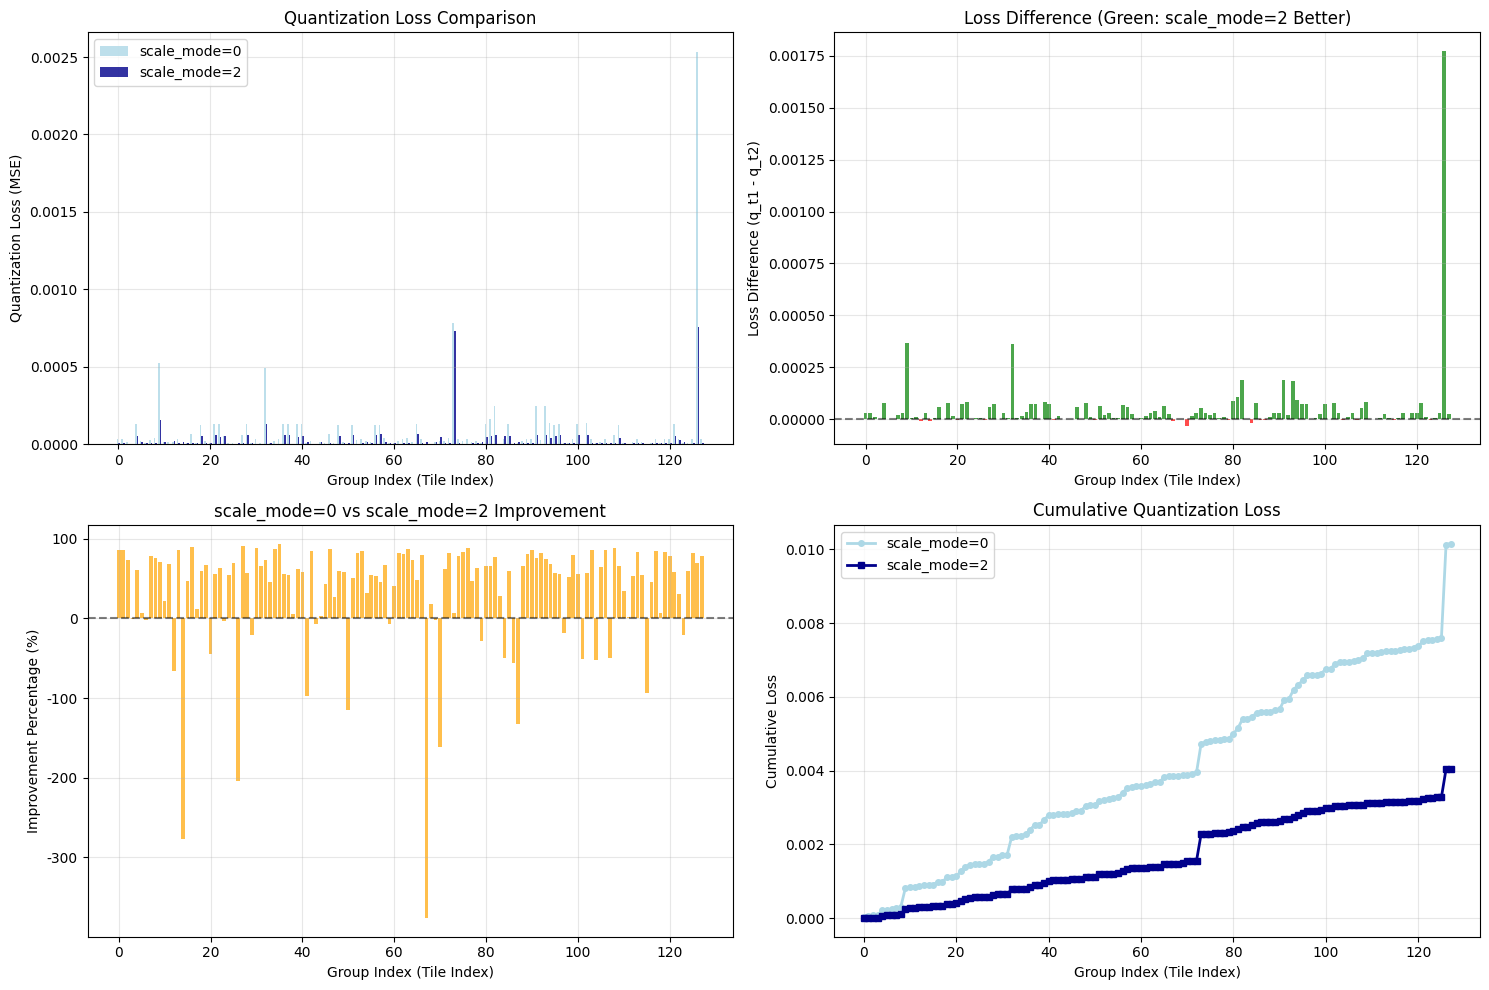

Quantization Loss Statistical Analysis
Metric               scale_mode=0    scale_mode=2    Improvement%
------------------------------------------------------------
Average Loss         0.000079        0.000032        34.97     
Total Loss           0.010161        0.004047        60.17     
Max Loss             0.002533        0.000760        94.09     
Min Loss             0.000002        0.000002        -376.34   
Std Dev              0.000240        0.000093       


In [9]:
# 绘制详细分析图
plot_detailed_quantization_analysis(q_t1_loss, q_t2_loss)

如果把量化损失分为两部分，一部分是由于scale 引入的夹断损失，另一部分是舍入到最邻近值的舍入损失。
很明显，PoT scale 会带来很大的夹断损失，并且这个损失比舍入损失的占比要大很多。

In [10]:
q_t3 = quantize_mx_op(token,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,
                      round='floor')

比较 PoT scale 使用哪种舍入算法计算更好，是floor还是RtN

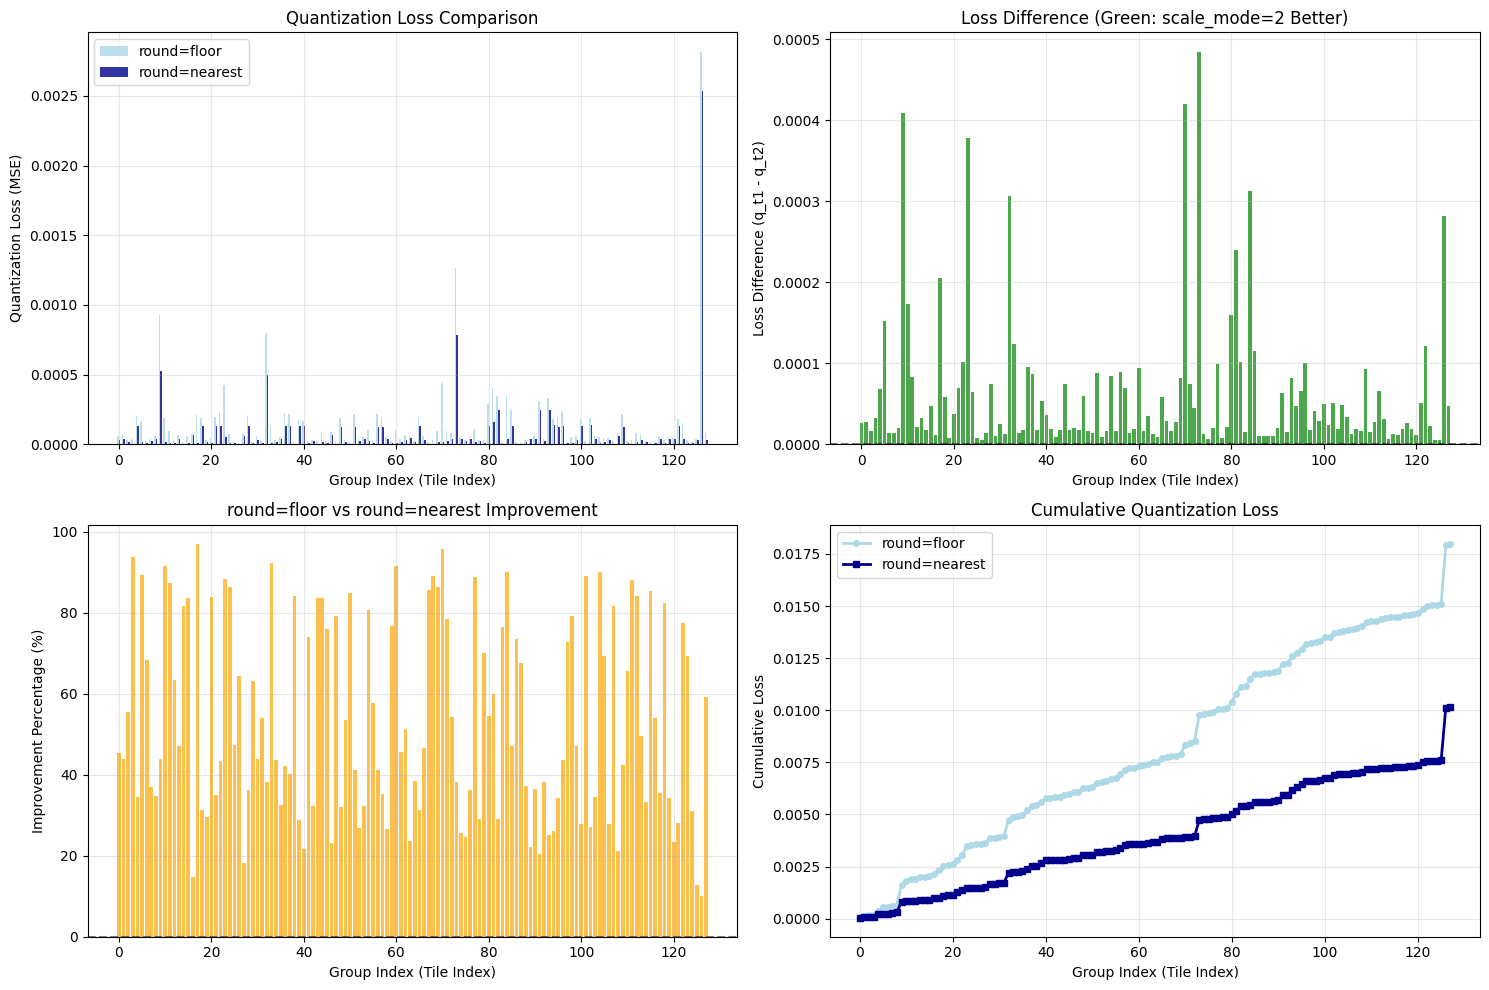

Quantization Loss Statistical Analysis
Metric               round=floor     round=nearest   Improvement%
------------------------------------------------------------
Average Loss         0.000141        0.000079        53.46     
Total Loss           0.017998        0.010161        43.54     
Max Loss             0.002815        0.002533        96.82     
Min Loss             0.000009        0.000002        10.03     
Std Dev              0.000291        0.000240       


In [11]:
q_t3_loss = compute_tile_quantization_loss(token, q_t3, block_size=32, loss_type='mse')
# 绘制详细分析图
plot_detailed_quantization_analysis(q_t3_loss, q_t1_loss, 'round=floor', 'round=nearest')

很明显RtN可以带来更好的结果。

RtN 与 even 比较，even是去最邻近偶数？
结果是一致的，不知为何。

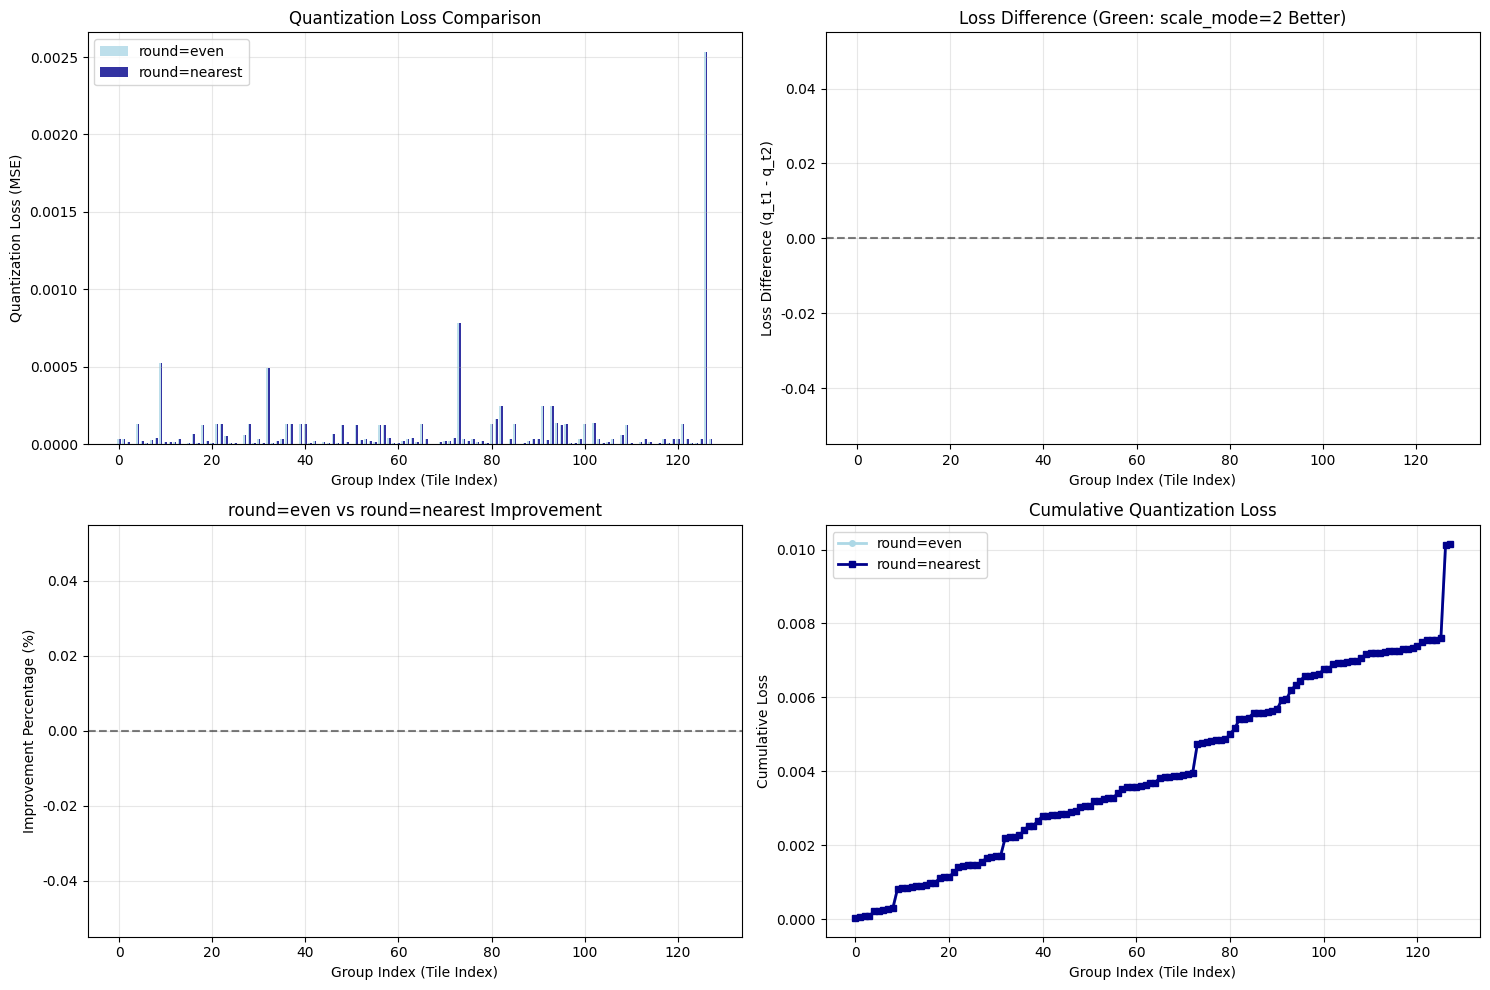

Quantization Loss Statistical Analysis
Metric               round=even      round=nearest   Improvement%
------------------------------------------------------------
Average Loss         0.000079        0.000079        0.00      
Total Loss           0.010161        0.010161        0.00      
Max Loss             0.002533        0.002533        0.00      
Min Loss             0.000002        0.000002        0.00      
Std Dev              0.000240        0.000240       


In [12]:
q_t4 = quantize_mx_op(token,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,
                      round='even')
q_t4_loss = compute_tile_quantization_loss(token, q_t4, block_size=32, loss_type='mse')
# 绘制详细分析图
plot_detailed_quantization_analysis(q_t4_loss, q_t1_loss, 'round=even', 'round=nearest')

In [13]:
scale_pot, _, _ = get_mx_quantize_params(
    token, mx_specs, elem_format="fp4_e2m1", block_size=32, axes=-1, scale_mode=0)
scale_fp16, _, _ = get_mx_quantize_params(
    token, mx_specs, elem_format="fp4_e2m1", block_size=32, axes=-1, scale_mode=2)

ValueError: too many values to unpack (expected 3)

In [ ]:
scaled_pot = (token.reshape(32, -1) / scale_pot).reshape(-1)
scaled_fp16 = (token.reshape(32, -1) / scale_fp16).reshape(-1)

In [ ]:
def plot_scaled_data_histograms(scaled_pot, scaled_fp16, bins=100):
    """
    绘制两种缩放数据的直方图对比
    """
    
    # 转换为 numpy 数组
    scaled_pot_np = scaled_pot.cpu().numpy() if hasattr(scaled_pot, 'cpu') else scaled_pot
    scaled_fp16_np = scaled_fp16.cpu().numpy() if hasattr(scaled_fp16, 'cpu') else scaled_fp16
    
    # 创建子图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 重叠直方图
    axes[0,0].hist(scaled_pot_np, bins=bins, alpha=0.7, label='PoT Scale (scale_mode=0)', 
                   color='lightblue', density=True)
    axes[0,0].hist(scaled_fp16_np, bins=bins, alpha=0.7, label='FP16 Scale (scale_mode=2)', 
                   color='darkblue', density=True)
    axes[0,0].set_xlabel('Scaled Values')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('Overlapped Histograms of Scaled Data')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 分别的直方图 - PoT
    axes[0,1].hist(scaled_pot_np, bins=bins, color='lightblue', alpha=0.8)
    axes[0,1].set_xlabel('Scaled Values')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('PoT Scale Distribution (scale_mode=0)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. 分别的直方图 - FP16
    axes[1,0].hist(scaled_fp16_np, bins=bins, color='darkblue', alpha=0.8)
    axes[1,0].set_xlabel('Scaled Values')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('FP16 Scale Distribution (scale_mode=2)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. 累积分布函数对比
    sorted_pot = np.sort(scaled_pot_np)
    sorted_fp16 = np.sort(scaled_fp16_np)
    y_pot = np.arange(1, len(sorted_pot) + 1) / len(sorted_pot)
    y_fp16 = np.arange(1, len(sorted_fp16) + 1) / len(sorted_fp16)
    
    axes[1,1].plot(sorted_pot, y_pot, label='PoT Scale', color='lightblue', linewidth=2)
    axes[1,1].plot(sorted_fp16, y_fp16, label='FP16 Scale', color='darkblue', linewidth=2)
    axes[1,1].set_xlabel('Scaled Values')
    axes[1,1].set_ylabel('Cumulative Probability')
    axes[1,1].set_title('Cumulative Distribution Functions')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("=" * 70)
    print("Scaled Data Statistical Analysis")
    print("=" * 70)
    print(f"{'Metric':<20} {'PoT Scale':<15} {'FP16 Scale':<15} {'Difference':<15}")
    print("-" * 70)
    print(f"{'Mean':<20} {np.mean(scaled_pot_np):<15.6f} {np.mean(scaled_fp16_np):<15.6f} {np.mean(scaled_pot_np) - np.mean(scaled_fp16_np):<15.6f}")
    print(f"{'Std Dev':<20} {np.std(scaled_pot_np):<15.6f} {np.std(scaled_fp16_np):<15.6f} {np.std(scaled_pot_np) - np.std(scaled_fp16_np):<15.6f}")
    print(f"{'Min':<20} {np.min(scaled_pot_np):<15.6f} {np.min(scaled_fp16_np):<15.6f} {np.min(scaled_pot_np) - np.min(scaled_fp16_np):<15.6f}")
    print(f"{'Max':<20} {np.max(scaled_pot_np):<15.6f} {np.max(scaled_fp16_np):<15.6f} {np.max(scaled_pot_np) - np.max(scaled_fp16_np):<15.6f}")
    print(f"{'Median':<20} {np.median(scaled_pot_np):<15.6f} {np.median(scaled_fp16_np):<15.6f} {np.median(scaled_pot_np) - np.median(scaled_fp16_np):<15.6f}")
    print(f"{'25th Percentile':<20} {np.percentile(scaled_pot_np, 25):<15.6f} {np.percentile(scaled_fp16_np, 25):<15.6f} {np.percentile(scaled_pot_np, 25) - np.percentile(scaled_fp16_np, 25):<15.6f}")
    print(f"{'75th Percentile':<20} {np.percentile(scaled_pot_np, 75):<15.6f} {np.percentile(scaled_fp16_np, 75):<15.6f} {np.percentile(scaled_pot_np, 75) - np.percentile(scaled_fp16_np, 75):<15.6f}")
    
    # 计算分布相似性
    from scipy import stats
    ks_stat, ks_p = stats.ks_2samp(scaled_pot_np, scaled_fp16_np)
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"KS Statistic: {ks_stat:.6f}")
    print(f"P-value: {ks_p:.6f}")
    print(f"Distributions are {'similar' if ks_p > 0.05 else 'significantly different'} (α=0.05)")


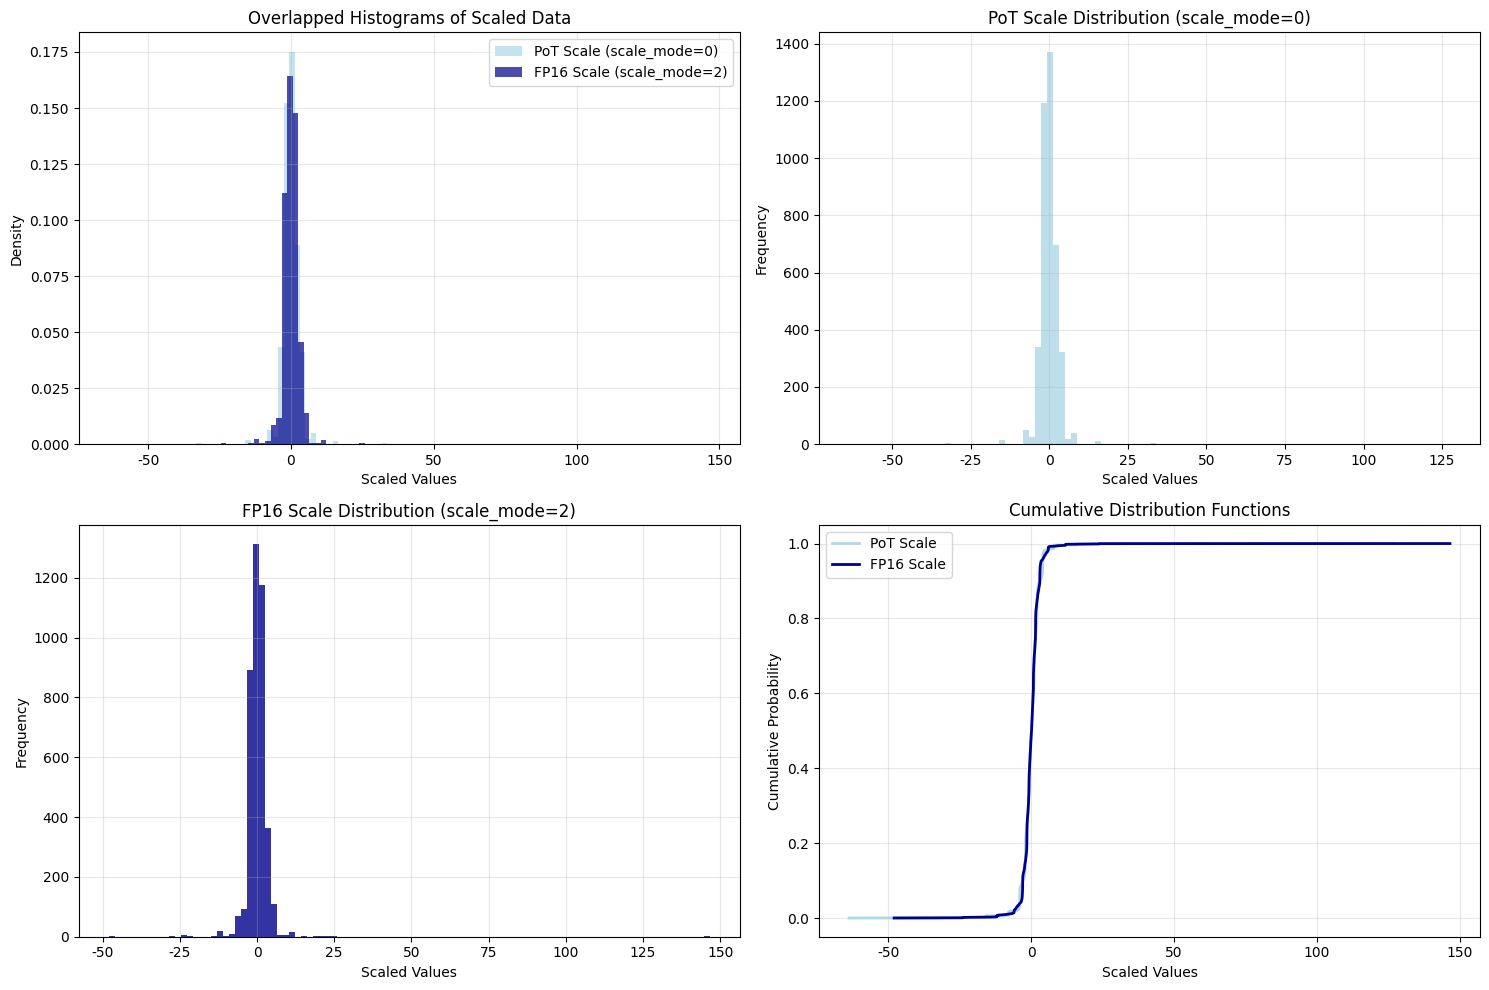

Scaled Data Statistical Analysis
Metric               PoT Scale       FP16 Scale      Difference     
----------------------------------------------------------------------
Mean                 0.008098        0.021849        -0.013750      
Std Dev              3.824042        3.747081        0.076961       
Min                  -63.750000      -48.000000      -15.750000     
Max                  127.500000      146.586823      -19.086823     
Median               0.107178        0.106782        0.000396       
25th Percentile      -1.367188       -1.455786       0.088599       
75th Percentile      1.460938        1.476923        -0.015986      

Kolmogorov-Smirnov Test:
KS Statistic: 0.060791
P-value: 0.000001
Distributions are significantly different (α=0.05)


In [ ]:
# 绘制直方图
plot_scaled_data_histograms(scaled_pot, scaled_fp16)

In [ ]:
from fast_hadamard_transform import hadamard_transform
import math
token_roted = hadamard_transform(token.reshape(-1, token.shape[0] // 32,
                                                      32), scale=1 / math.sqrt(32)).reshape(-1)

In [ ]:
p_rt1 = quantize_mx_op(token_roted,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
p_rt2 = quantize_mx_op(token_roted,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=2)

比较分组旋转后 scale 的影响，还是fp16好。

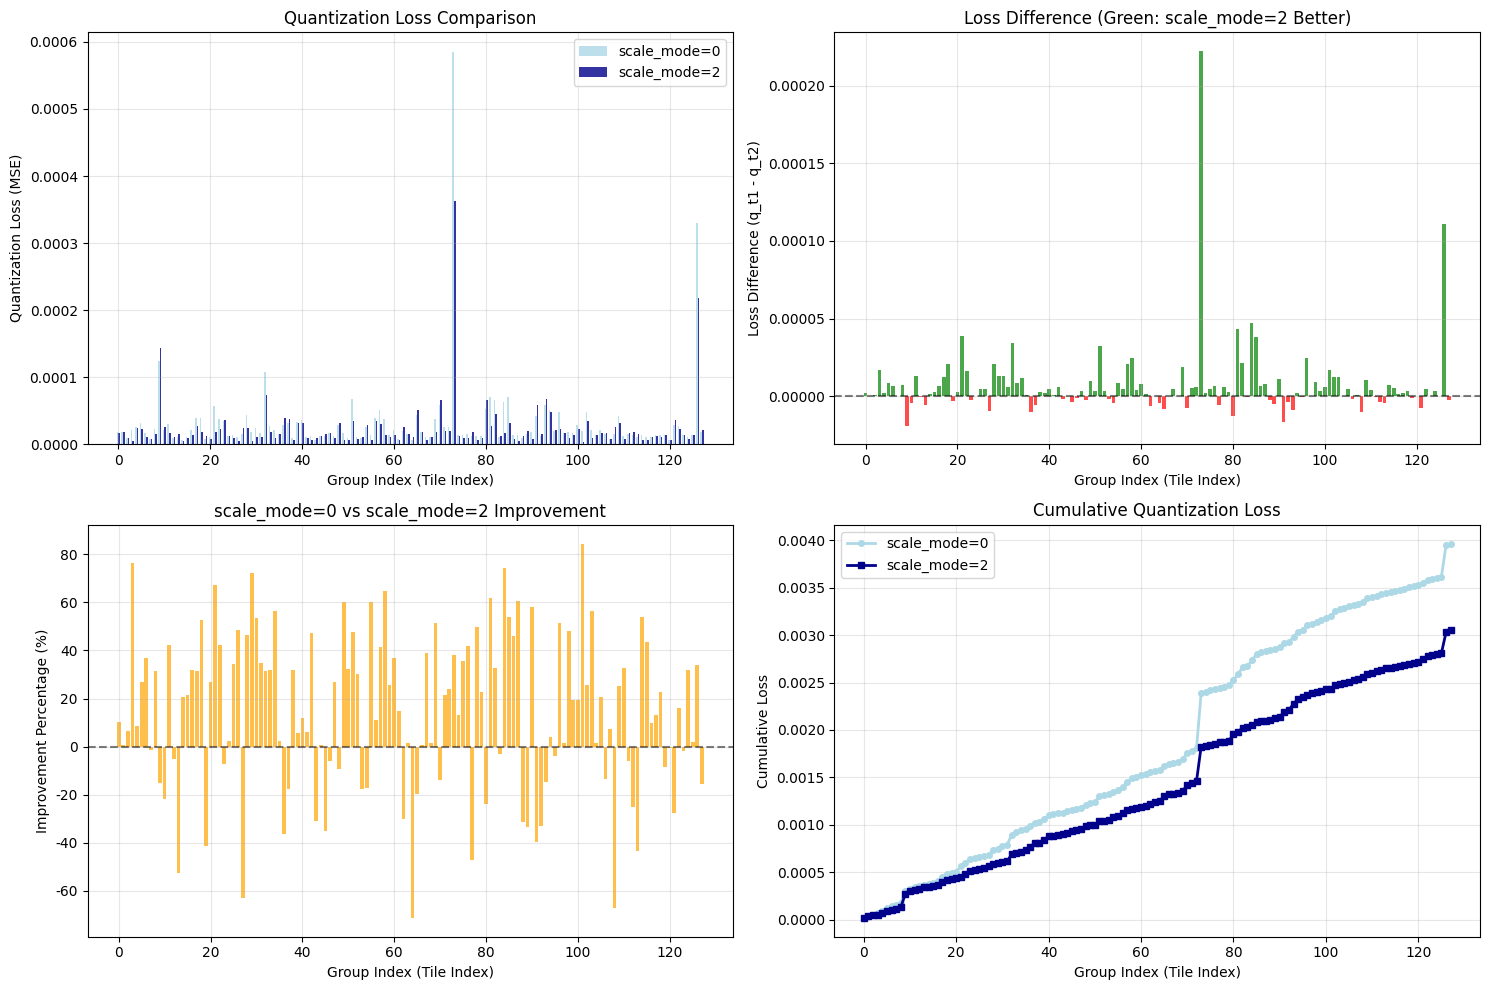

Quantization Loss Statistical Analysis
Metric               scale_mode=0    scale_mode=2    Improvement%
------------------------------------------------------------
Average Loss         0.000031        0.000024        14.87     
Total Loss           0.003966        0.003050        23.10     
Max Loss             0.000585        0.000363        84.45     
Min Loss             0.000006        0.000003        -71.27    
Std Dev              0.000059        0.000039       


In [ ]:
p_rt1_loss = compute_tile_quantization_loss(token_roted, p_rt1, block_size=32, loss_type='mse')
p_rt2_loss = compute_tile_quantization_loss(token_roted, p_rt2, block_size=32, loss_type='mse')
# 绘制详细分析图
plot_detailed_quantization_analysis(p_rt1_loss, p_rt2_loss, 'scale_mode=0', 'scale_mode=2')

In [ ]:

def analyze_tile_details(original, quantized, tile_index, block_size=32, title_prefix=""):
    """
    分析指定tile的详细量化情况
    
    Args:
        original: 原始张量
        quantized: 量化后的张量
        tile_index: 要分析的tile索引
        block_size: tile大小
        title_prefix: 图表标题前缀
    """
    
    # 转换为numpy
    original_np = original.cpu().numpy() if hasattr(original, 'cpu') else original
    quantized_np = quantized.cpu().numpy() if hasattr(quantized, 'cpu') else quantized
    
    # 计算padding并重塑为tiles
    seq_len = len(original_np)
    num_tiles = (seq_len + block_size - 1) // block_size
    padded_len = num_tiles * block_size
    
    if padded_len > seq_len:
        padding = padded_len - seq_len
        original_padded = np.pad(original_np, (0, padding))
        quantized_padded = np.pad(quantized_np, (0, padding))
    else:
        original_padded = original_np
        quantized_padded = quantized_np
    
    # 重塑为tiles
    original_tiles = original_padded.reshape(-1, block_size)
    quantized_tiles = quantized_padded.reshape(-1, block_size)
    
    # 获取指定tile的数据
    orig_tile = original_tiles[tile_index]
    quant_tile = quantized_tiles[tile_index]
    
    # 计算每个元素的损失
    element_losses = (orig_tile - quant_tile) ** 2
    element_indices = np.arange(block_size)
    
    # 创建详细分析图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 原始值 vs 量化值对比
    axes[0,0].plot(element_indices, orig_tile, 'o-', label='Original', 
                   color='blue', linewidth=2, markersize=4)
    axes[0,0].plot(element_indices, quant_tile, 's-', label='Quantized', 
                   color='red', linewidth=2, markersize=4)
    axes[0,0].set_xlabel('Element Index in Tile')
    axes[0,0].set_ylabel('Value')
    axes[0,0].set_title(f'{title_prefix}Tile {tile_index}: Original vs Quantized')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 每个元素的量化误差
    axes[0,1].bar(element_indices, orig_tile - quant_tile, 
                  color='orange', alpha=0.7)
    axes[0,1].set_xlabel('Element Index in Tile')
    axes[0,1].set_ylabel('Quantization Error (Original - Quantized)')
    axes[0,1].set_title(f'Tile {tile_index}: Quantization Error per Element')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 3. 每个元素的平方误差（MSE贡献）
    colors = ['red' if loss == np.max(element_losses) else 'lightcoral' for loss in element_losses]
    bars = axes[1,0].bar(element_indices, element_losses, color=colors, alpha=0.7)
    axes[1,0].set_xlabel('Element Index in Tile')
    axes[1,0].set_ylabel('Squared Error (MSE Contribution)')
    axes[1,0].set_title(f'Tile {tile_index}: MSE Contribution per Element')
    axes[1,0].grid(True, alpha=0.3)
    
    # 标记最大损失的元素
    max_loss_idx = np.argmax(element_losses)
    axes[1,0].annotate(f'Max Loss\nIndex: {max_loss_idx}\nValue: {element_losses[max_loss_idx]:.6f}',
                       xy=(max_loss_idx, element_losses[max_loss_idx]),
                       xytext=(max_loss_idx + 3, element_losses[max_loss_idx] * 1.2),
                       arrowprops=dict(arrowstyle='->', color='black'),
                       fontsize=10, ha='left')
    
    # 4. 相对误差百分比
    relative_error = np.abs(orig_tile - quant_tile) / (np.abs(orig_tile) + 1e-8) * 100
    axes[1,1].bar(element_indices, relative_error, color='purple', alpha=0.7)
    axes[1,1].set_xlabel('Element Index in Tile')
    axes[1,1].set_ylabel('Relative Error (%)')
    axes[1,1].set_title(f'Tile {tile_index}: Relative Error per Element')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细统计信息
    print("=" * 80)
    print(f"Detailed Analysis for {title_prefix}Tile {tile_index}")
    print("=" * 80)
    print(f"Tile MSE: {np.mean(element_losses):.8f}")
    print(f"Tile Max Squared Error: {np.max(element_losses):.8f} (at index {max_loss_idx})")
    print(f"Tile Min Squared Error: {np.min(element_losses):.8f}")
    print(f"Tile Mean Absolute Error: {np.mean(np.abs(orig_tile - quant_tile)):.8f}")
    print()
    
    # 找出损失最大的几个元素
    top_loss_indices = np.argsort(element_losses)[-5:][::-1]  # 前5个最大损失
    print("Top 5 elements with highest squared error:")
    print(f"{'Index':<8} {'Original':<12} {'Quantized':<12} {'Error':<12} {'Squared Error':<15} {'Rel Error %':<12}")
    print("-" * 80)
    for idx in top_loss_indices:
        orig_val = orig_tile[idx]
        quant_val = quant_tile[idx]
        error = orig_val - quant_val
        sq_error = element_losses[idx]
        rel_error = np.abs(error) / (np.abs(orig_val) + 1e-8) * 100
        print(f"{idx:<8} {orig_val:<12.6f} {quant_val:<12.6f} {error:<12.6f} {sq_error:<15.8f} {rel_error:<12.2f}")


可视化 fp16 与 PoT 中量化损失最大的组，观察损失在哪里产生的。

发现损失是由于组内outlier 产生的。使用 PoT scale 无法还原 outlier, 又由于 outlier 的尺度通常很大，因此会产生极大的量化损失。

排序和旋转都可以将组内数据尽可能地旋转到相近地尺度上，并且降低组内 outlier 的尺度，进而减小量化误差。

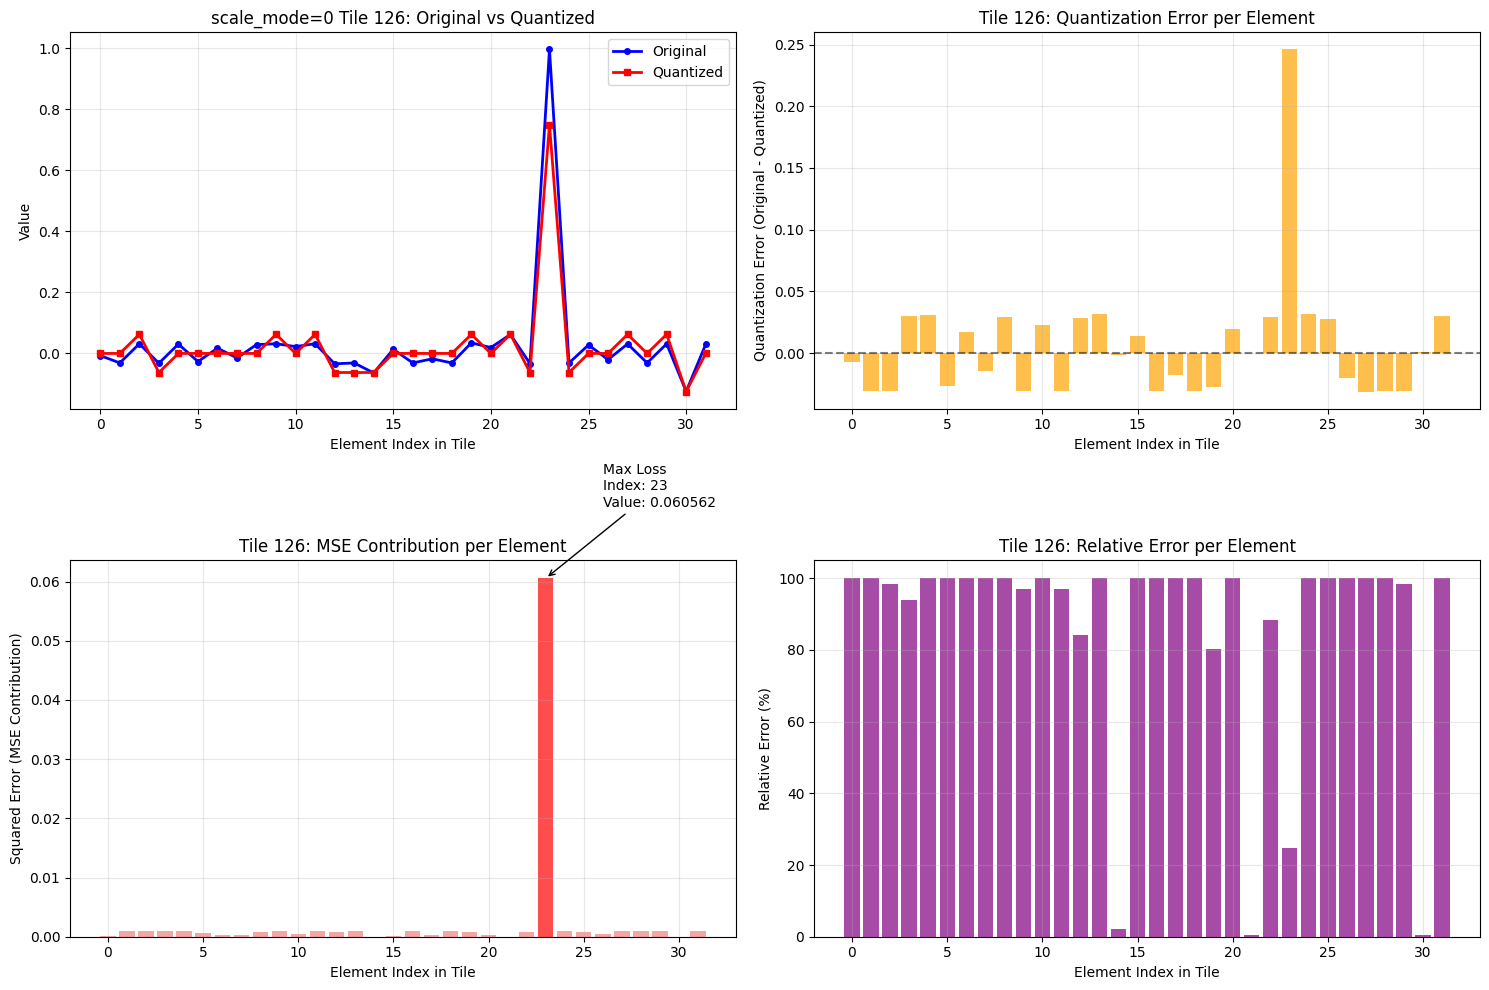

Detailed Analysis for scale_mode=0 Tile 126
Tile MSE: 0.00253300
Tile Max Squared Error: 0.06056213 (at index 23)
Tile Min Squared Error: 0.00000006
Tile Mean Absolute Error: 0.03069878

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
23       0.996094     0.750000     0.246094     0.06056213      24.71       
24       -0.031250    -0.062500    0.031250     0.00097656      100.00      
27       0.031250     0.062500     -0.031250    0.00097656      100.00      
13       -0.031250    -0.062500    0.031250     0.00097656      100.00      
18       -0.031128    0.000000     -0.031128    0.00096895      100.00      

For comparison, let's also analyze scale_mode=2:


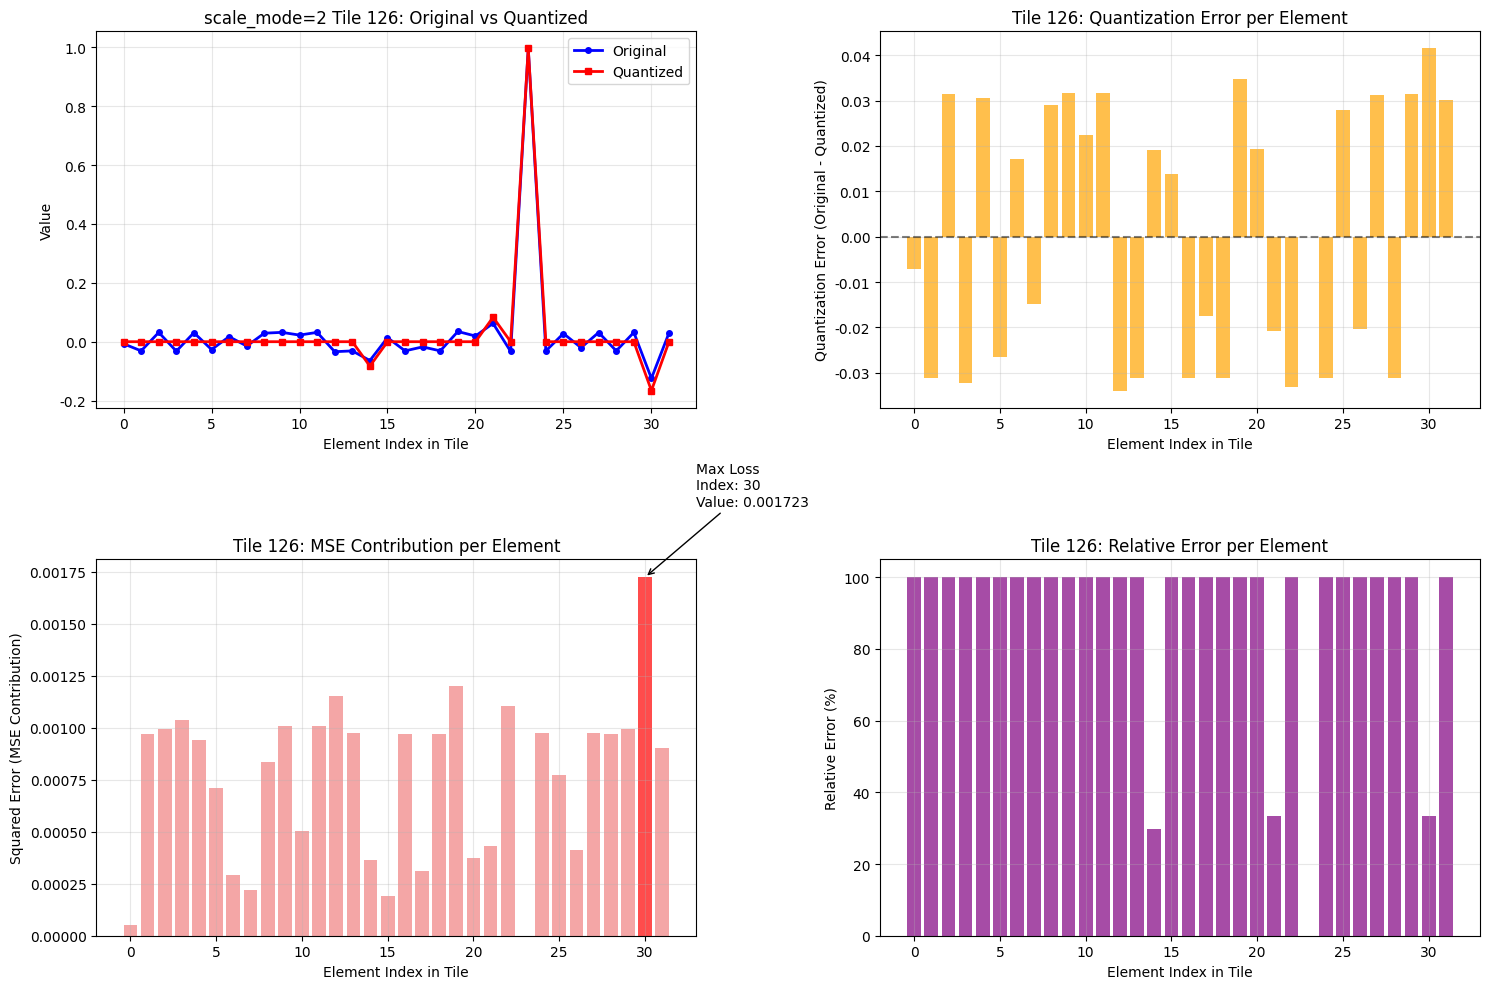

Detailed Analysis for scale_mode=2 Tile 126
Tile MSE: 0.00075999
Tile Max Squared Error: 0.00172257 (at index 30)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.02613640

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
30       -0.124512    -0.166016    0.041504     0.00172257      33.33       
19       0.034668     0.000000     0.034668     0.00120187      100.00      
12       -0.033936    0.000000     -0.033936    0.00115162      100.00      
22       -0.033203    0.000000     -0.033203    0.00110245      100.00      
3        -0.032227    0.000000     -0.032227    0.00103855      100.00      


In [ ]:
# 分析第127组的详细情况
analyze_tile_details(token, q_t1, tile_index=126, title_prefix="scale_mode=0 ")

# 也分析一下scale_mode=2的情况作为对比
print("\n" + "="*100)
print("For comparison, let's also analyze scale_mode=2:")
print("="*100)
analyze_tile_details(token, q_t2, tile_index=126, title_prefix="scale_mode=2 ")

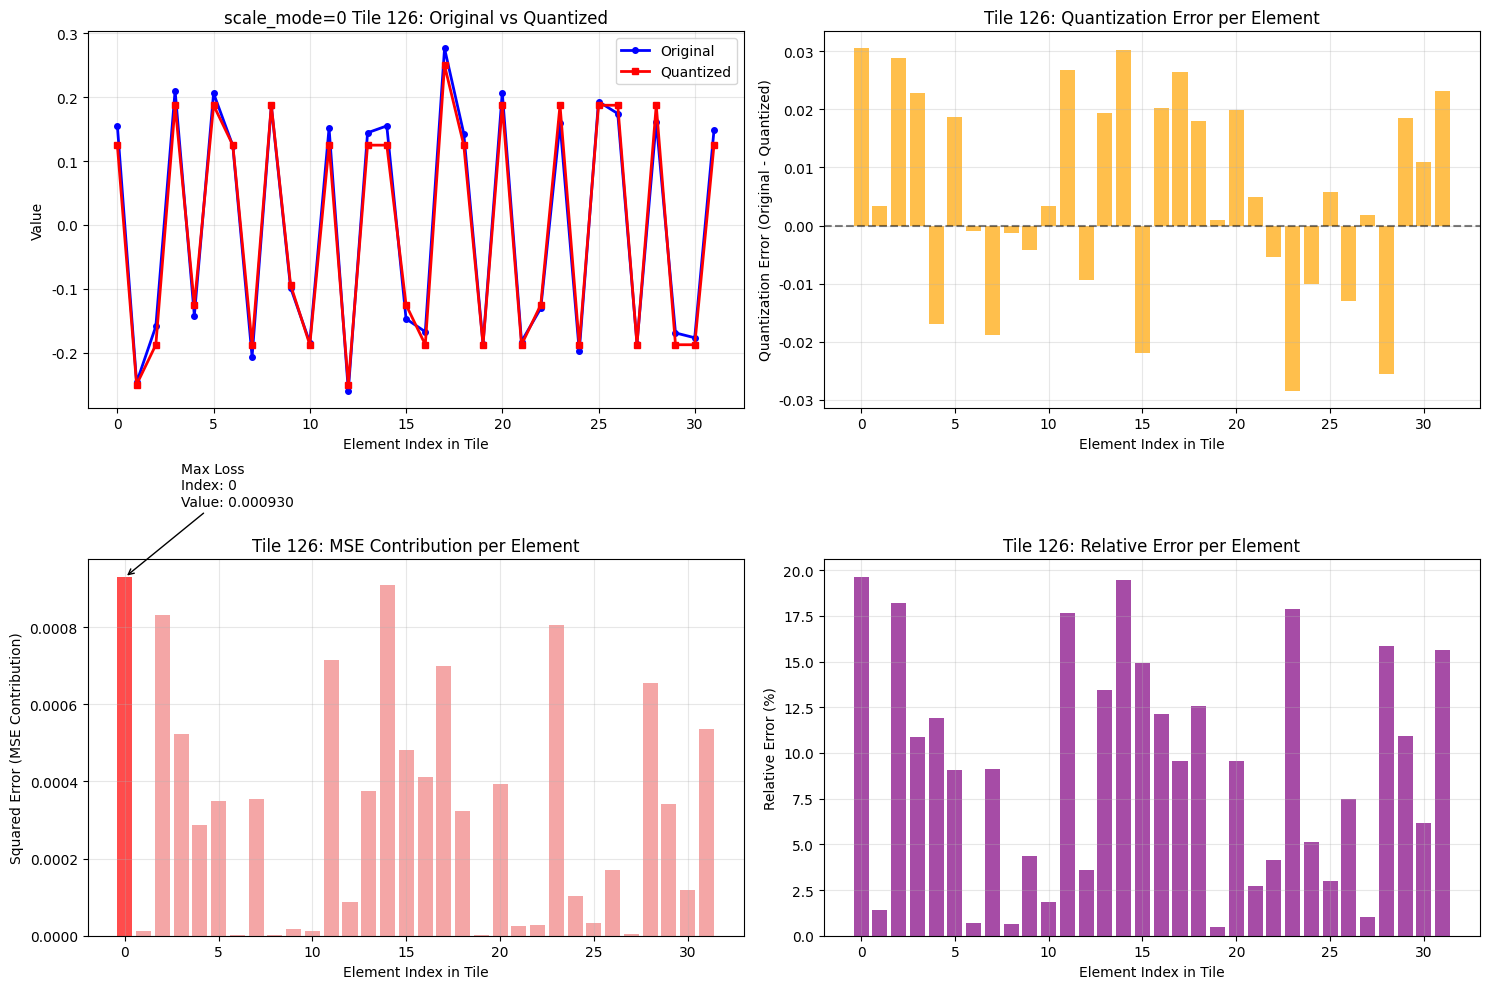

Detailed Analysis for scale_mode=0 Tile 126
Tile MSE: 0.00032947
Tile Max Squared Error: 0.00092957 (at index 0)
Tile Min Squared Error: 0.00000076
Tile Mean Absolute Error: 0.01533263

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
0        0.155489     0.125000     0.030489     0.00092957      19.61       
14       0.155165     0.125000     0.030165     0.00090994      19.44       
2        -0.158639    -0.187500    0.028861     0.00083294      18.19       
23       0.159093     0.187500     -0.028407    0.00080698      17.86       
11       0.151756     0.125000     0.026756     0.00071586      17.63       

For comparison, let's also analyze scale_mode=2:


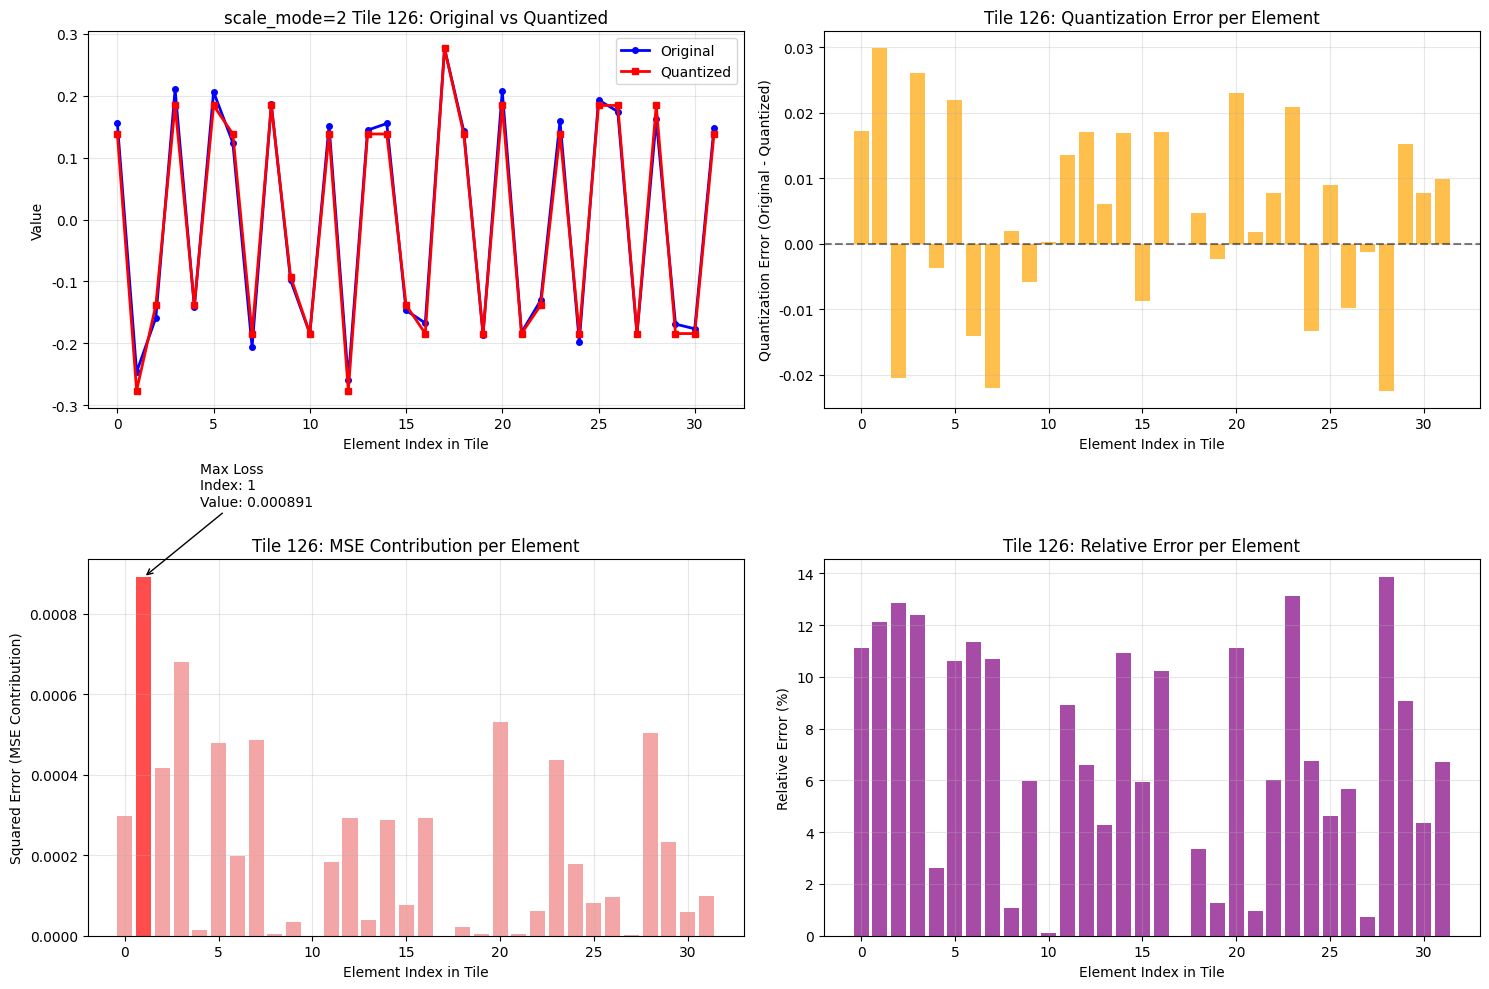

Detailed Analysis for scale_mode=2 Tile 126
Tile MSE: 0.00021824
Tile Max Squared Error: 0.00089067 (at index 1)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.01226417

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
1        -0.246596    -0.276440    0.029844     0.00089067      12.10       
3        0.210386     0.184293     0.026093     0.00068084      12.40       
20       0.207344     0.184293     0.023050     0.00053131      11.12       
28       0.161876     0.184293     -0.022417    0.00050253      13.85       
7        -0.206329    -0.184293    -0.022036    0.00048558      10.68       


In [ ]:
# 分析第127组的详细情况
analyze_tile_details(token_roted, p_rt1, tile_index=126, title_prefix="scale_mode=0 ")
# 也分析一下scale_mode=2的情况作为对比
print("\n" + "="*100)
print("For comparison, let's also analyze scale_mode=2:")
print("="*100)
analyze_tile_details(token_roted, p_rt2, tile_index=126, title_prefix="scale_mode=2 ")

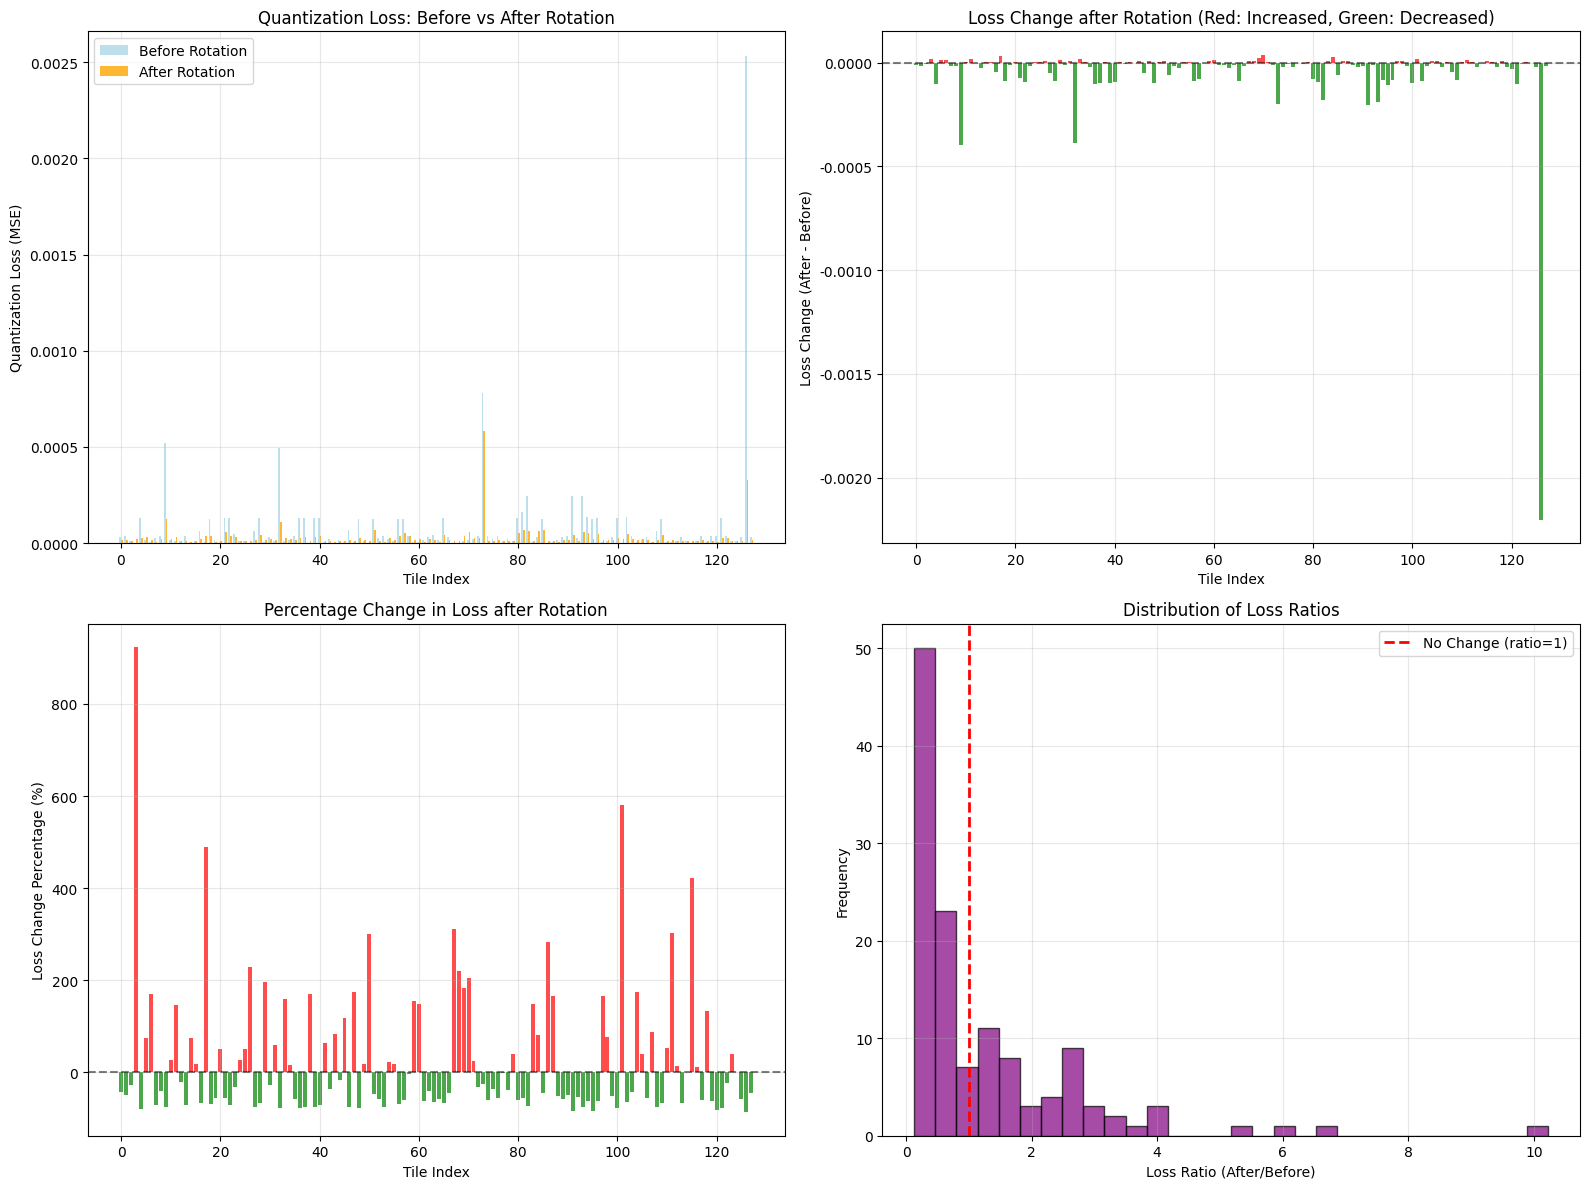

Rotation Effect on Quantization Loss (scale_mode=0)
Total tiles: 128
Tiles with increased loss: 52 (40.6%)
Tiles with decreased loss: 76 (59.4%)
Tiles with unchanged loss: 0 (0.0%)

Overall Statistics:
Metric                    Before Rotation After Rotation  Change         
--------------------------------------------------------------------------------
Mean Loss                 0.00007938      0.00003099      -0.00004840    
Total Loss                0.010161        0.003966        -0.006195      
Max Loss                  0.00253300      0.00058509      0.00194791     
Min Loss                  0.00000212      0.00000641      -0.00000429    
Std Dev                   0.00024038      0.00005921      -0.00018118    

Loss Change Analysis:
Mean loss change: -0.00004840
Mean percentage change: 26.66%
Max loss increase: 0.00003915 (tile 70)
Max loss decrease: -0.00220353 (tile 126)

Top 10 tiles with highest loss increase:
Tile Index   Before          After           Increase        % Ch

In [ ]:
def compare_rotation_effect(original_loss, rotated_loss, title="Rotation Effect Analysis"):
    """
    比较旋转前后的量化损失
    
    Args:
        original_loss: 旋转前的量化损失
        rotated_loss: 旋转后的量化损失
        title: 图表标题
    """
    
    # 转换为 numpy
    orig_np = original_loss.cpu().numpy() if hasattr(original_loss, 'cpu') else original_loss
    rot_np = rotated_loss.cpu().numpy() if hasattr(rotated_loss, 'cpu') else rotated_loss
    
    num_tiles = len(orig_np)
    tile_indices = np.arange(num_tiles)
    
    # 计算损失变化
    loss_diff = rot_np - orig_np  # 正值表示旋转后损失增加
    loss_ratio = rot_np / (orig_np + 1e-8)  # 损失比率
    loss_change_percent = (loss_diff / (orig_np + 1e-8)) * 100  # 损失变化百分比
    
    # 创建详细分析图
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 旋转前后损失对比
    width = 0.35
    axes[0,0].bar(tile_indices - width/2, orig_np, width, 
                  label='Before Rotation', color='lightblue', alpha=0.8)
    axes[0,0].bar(tile_indices + width/2, rot_np, width, 
                  label='After Rotation', color='orange', alpha=0.8)
    axes[0,0].set_xlabel('Tile Index')
    axes[0,0].set_ylabel('Quantization Loss (MSE)')
    axes[0,0].set_title('Quantization Loss: Before vs After Rotation')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 损失变化（绝对值）
    colors = ['red' if d > 0 else 'green' for d in loss_diff]
    bars = axes[0,1].bar(tile_indices, loss_diff, color=colors, alpha=0.7)
    axes[0,1].set_xlabel('Tile Index')
    axes[0,1].set_ylabel('Loss Change (After - Before)')
    axes[0,1].set_title('Loss Change after Rotation (Red: Increased, Green: Decreased)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 3. 损失变化百分比
    colors_pct = ['red' if p > 0 else 'green' for p in loss_change_percent]
    axes[1,0].bar(tile_indices, loss_change_percent, color=colors_pct, alpha=0.7)
    axes[1,0].set_xlabel('Tile Index')
    axes[1,0].set_ylabel('Loss Change Percentage (%)')
    axes[1,0].set_title('Percentage Change in Loss after Rotation')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 4. 损失比率分布
    axes[1,1].hist(loss_ratio, bins=30, color='purple', alpha=0.7, edgecolor='black')
    axes[1,1].axvline(x=1, color='red', linestyle='--', linewidth=2, label='No Change (ratio=1)')
    axes[1,1].set_xlabel('Loss Ratio (After/Before)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Loss Ratios')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 统计分析
    increased_tiles = np.where(loss_diff > 0)[0]
    decreased_tiles = np.where(loss_diff < 0)[0]
    unchanged_tiles = np.where(np.abs(loss_diff) < 1e-8)[0]
    
    print("=" * 80)
    print(f"{title}")
    print("=" * 80)
    print(f"Total tiles: {num_tiles}")
    print(f"Tiles with increased loss: {len(increased_tiles)} ({len(increased_tiles)/num_tiles*100:.1f}%)")
    print(f"Tiles with decreased loss: {len(decreased_tiles)} ({len(decreased_tiles)/num_tiles*100:.1f}%)")
    print(f"Tiles with unchanged loss: {len(unchanged_tiles)} ({len(unchanged_tiles)/num_tiles*100:.1f}%)")
    print()
    
    print("Overall Statistics:")
    print(f"{'Metric':<25} {'Before Rotation':<15} {'After Rotation':<15} {'Change':<15}")
    print("-" * 80)
    print(f"{'Mean Loss':<25} {np.mean(orig_np):<15.8f} {np.mean(rot_np):<15.8f} {np.mean(loss_diff):<15.8f}")
    print(f"{'Total Loss':<25} {np.sum(orig_np):<15.6f} {np.sum(rot_np):<15.6f} {np.sum(loss_diff):<15.6f}")
    print(f"{'Max Loss':<25} {np.max(orig_np):<15.8f} {np.max(rot_np):<15.8f} {np.max(orig_np) - np.max(rot_np):<15.8f}")
    print(f"{'Min Loss':<25} {np.min(orig_np):<15.8f} {np.min(rot_np):<15.8f} {np.min(orig_np) - np.min(rot_np):<15.8f}")
    print(f"{'Std Dev':<25} {np.std(orig_np):<15.8f} {np.std(rot_np):<15.8f} {np.std(rot_np) - np.std(orig_np):<15.8f}")
    print()
    
    print("Loss Change Analysis:")
    print(f"Mean loss change: {np.mean(loss_diff):.8f}")
    print(f"Mean percentage change: {np.mean(loss_change_percent):.2f}%")
    print(f"Max loss increase: {np.max(loss_diff):.8f} (tile {np.argmax(loss_diff)})")
    print(f"Max loss decrease: {np.min(loss_diff):.8f} (tile {np.argmin(loss_diff)})")
    print()
    
    # 找出损失增加最多的tiles
    if len(increased_tiles) > 0:
        print("Top 10 tiles with highest loss increase:")
        sorted_increase_indices = increased_tiles[np.argsort(loss_diff[increased_tiles])[::-1]][:10]
        print(f"{'Tile Index':<12} {'Before':<15} {'After':<15} {'Increase':<15} {'% Change':<12}")
        print("-" * 80)
        for idx in sorted_increase_indices:
            before = orig_np[idx]
            after = rot_np[idx]
            increase = loss_diff[idx]
            pct_change = loss_change_percent[idx]
            print(f"{idx:<12} {before:<15.8f} {after:<15.8f} {increase:<15.8f} {pct_change:<12.2f}")
        print()
    
    # 找出损失减少最多的tiles
    if len(decreased_tiles) > 0:
        print("Top 10 tiles with highest loss decrease:")
        sorted_decrease_indices = decreased_tiles[np.argsort(loss_diff[decreased_tiles])][:10]
        print(f"{'Tile Index':<12} {'Before':<15} {'After':<15} {'Decrease':<15} {'% Change':<12}")
        print("-" * 80)
        for idx in sorted_decrease_indices:
            before = orig_np[idx]
            after = rot_np[idx]
            decrease = loss_diff[idx]
            pct_change = loss_change_percent[idx]
            print(f"{idx:<12} {before:<15.8f} {after:<15.8f} {decrease:<15.8f} {pct_change:<12.2f}")
    
    return {
        'increased_tiles': increased_tiles,
        'decreased_tiles': decreased_tiles,
        'loss_diff': loss_diff,
        'loss_change_percent': loss_change_percent,
        'loss_ratio': loss_ratio
    }

# 比较旋转前后的损失
rotation_analysis = compare_rotation_effect(q_t1_loss, p_rt1_loss, "Rotation Effect on Quantization Loss (scale_mode=0)")

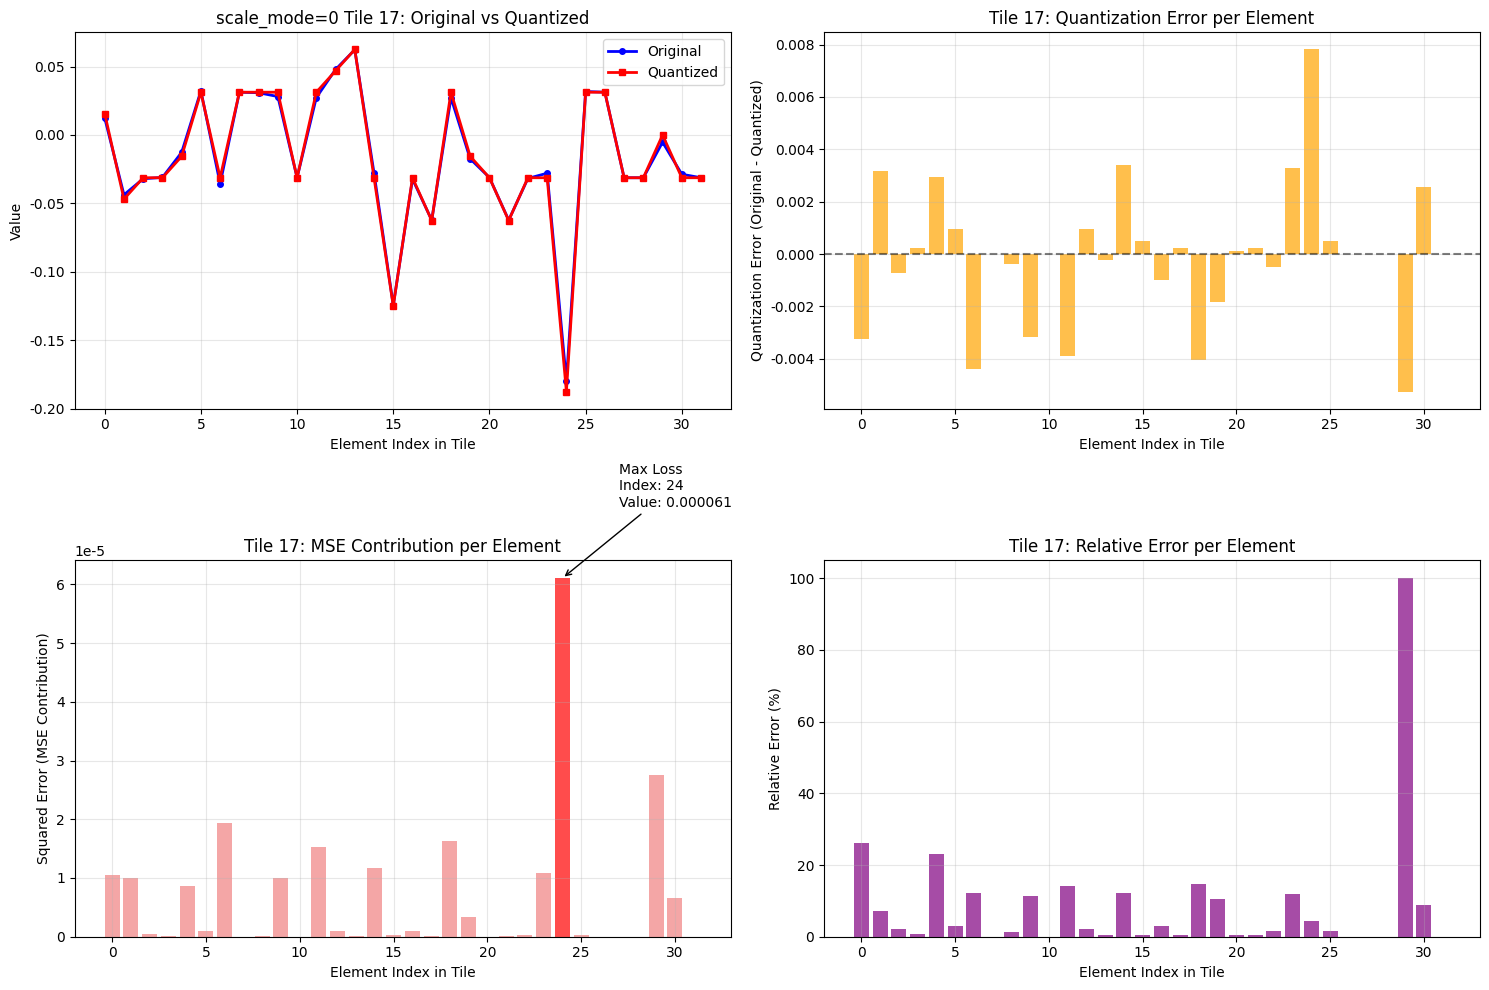

Detailed Analysis for scale_mode=0 Tile 17
Tile MSE: 0.00000674
Tile Max Squared Error: 0.00006104 (at index 24)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.00173759

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
24       -0.179688    -0.187500    0.007812     0.00006104      4.35        
29       -0.005249    0.000000     -0.005249    0.00002755      100.00      
6        -0.035645    -0.031250    -0.004395    0.00001931      12.33       
18       0.027222     0.031250     -0.004028    0.00001623      14.80       
11       0.027344     0.031250     -0.003906    0.00001526      14.29       


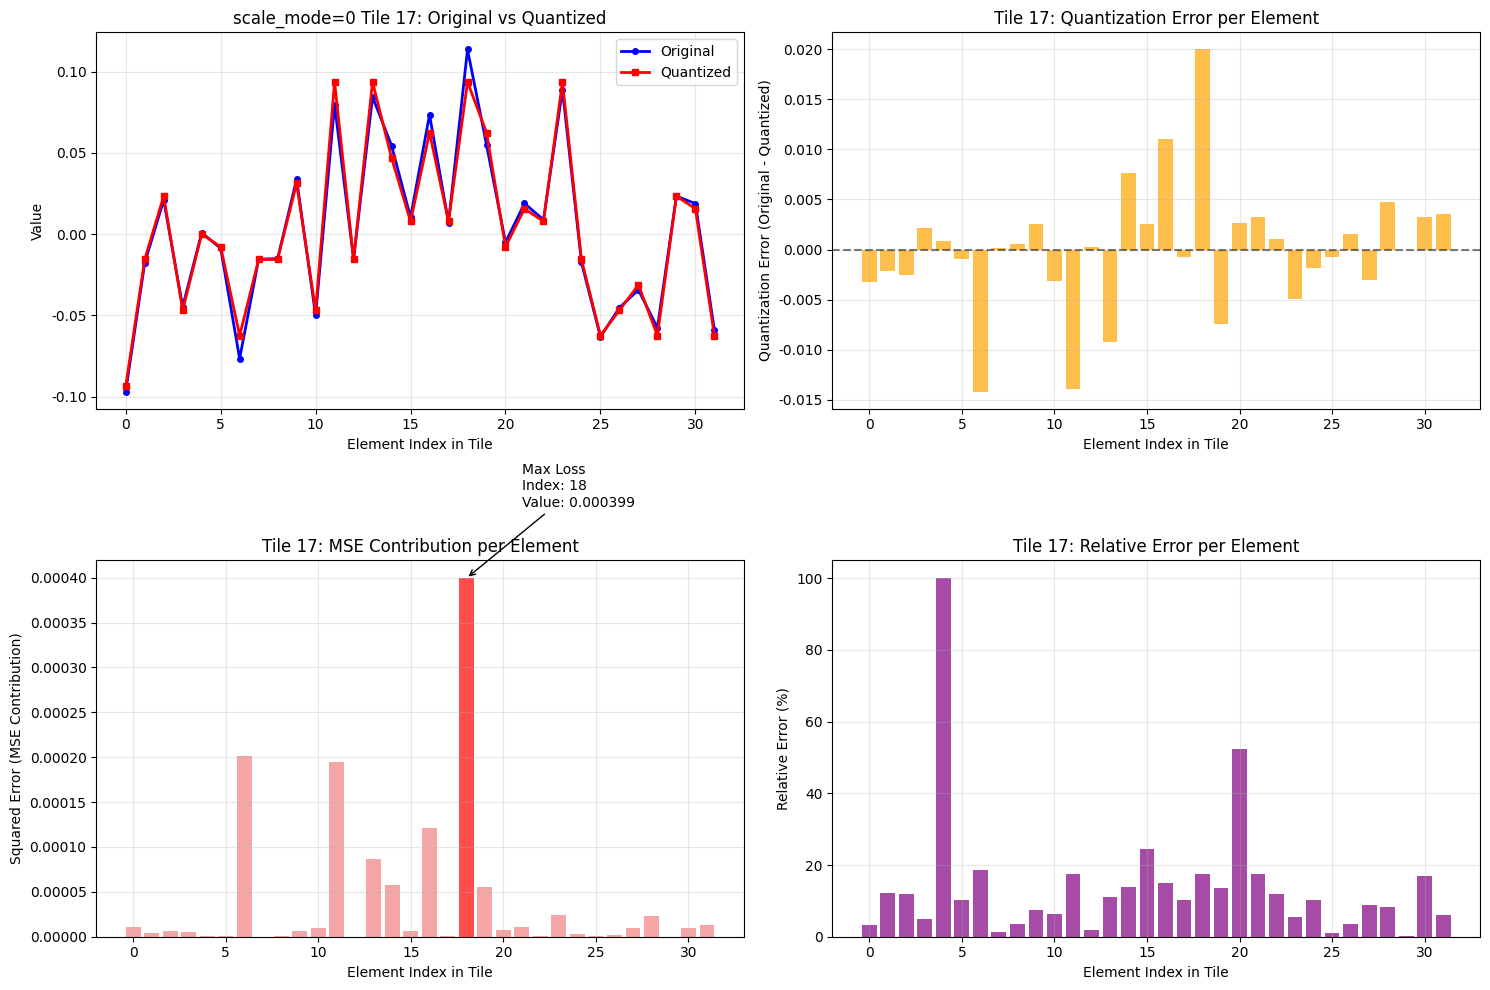

Detailed Analysis for scale_mode=0 Tile 17
Tile MSE: 0.00003972
Tile Max Squared Error: 0.00039932 (at index 18)
Tile Min Squared Error: 0.00000001
Tile Mean Absolute Error: 0.00424521

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
18       0.113733     0.093750     0.019983     0.00039932      17.57       
6        -0.076682    -0.062500    -0.014182    0.00020112      18.49       
11       0.079811     0.093750     -0.013939    0.00019431      17.47       
16       0.073509     0.062500     0.011009     0.00012121      14.98       
13       0.084472     0.093750     -0.009278    0.00008609      10.98       


In [ ]:
# 分析第70组的详细情况
analyze_tile_details(token, q_t1, tile_index=17, title_prefix="scale_mode=0 ")
analyze_tile_details(token_roted, p_rt1, tile_index=17, title_prefix="scale_mode=0 ")

In [ ]:
# 对token按绝对值大小做降序排序
_, index = torch.sort(token.abs(), descending=True)
sorted_token = token[index]*2.3123  # 当组内的outlier接近 2**x 时，旋转后的结果可能会变差
sorted_q_t1 = quantize_mx_op(sorted_token,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)

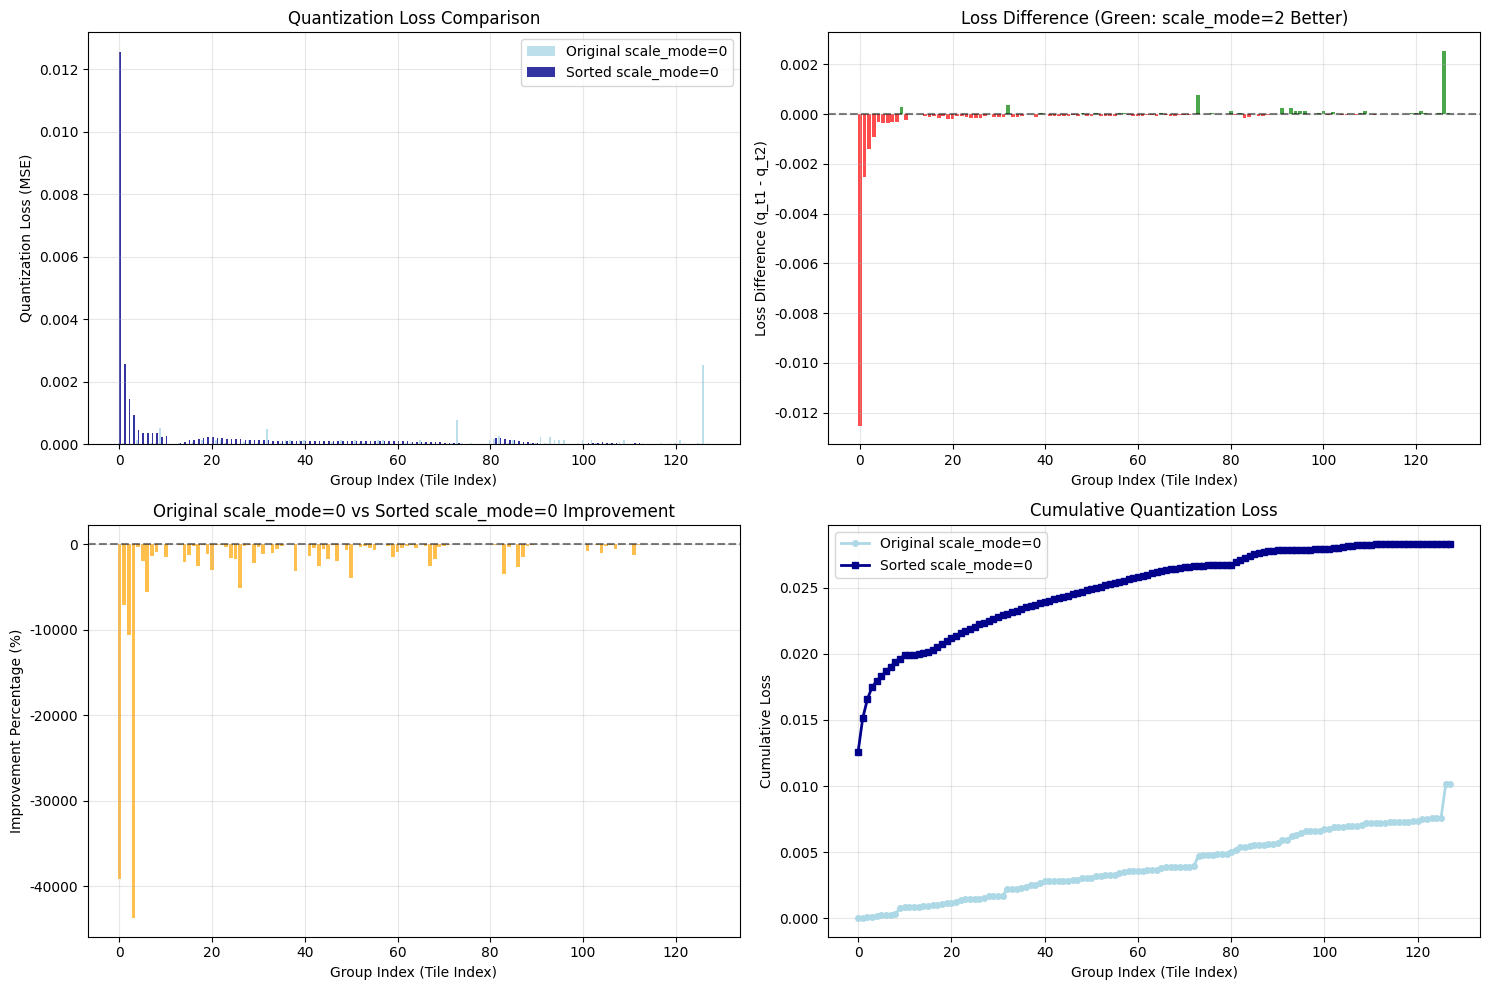

Quantization Loss Statistical Analysis
Metric               Original scale_mode=0 Sorted scale_mode=0 Improvement%
------------------------------------------------------------
Average Loss         0.000079        0.000221        -1339.14  
Total Loss           0.010161        0.028328        -178.79   
Max Loss             0.002533        0.012548        100.00    
Min Loss             0.000002        0.000000        -43707.82 
Std Dev              0.000240        0.001127       


In [ ]:
# 绘制排序后量化损失
sorted_q_t1_loss = compute_tile_quantization_loss(sorted_token, sorted_q_t1,
                                                  block_size=32, loss_type='mse')
# 绘制详细分析图
plot_detailed_quantization_analysis(q_t1_loss, sorted_q_t1_loss, 'Original scale_mode=0',
                                    'Sorted scale_mode=0')

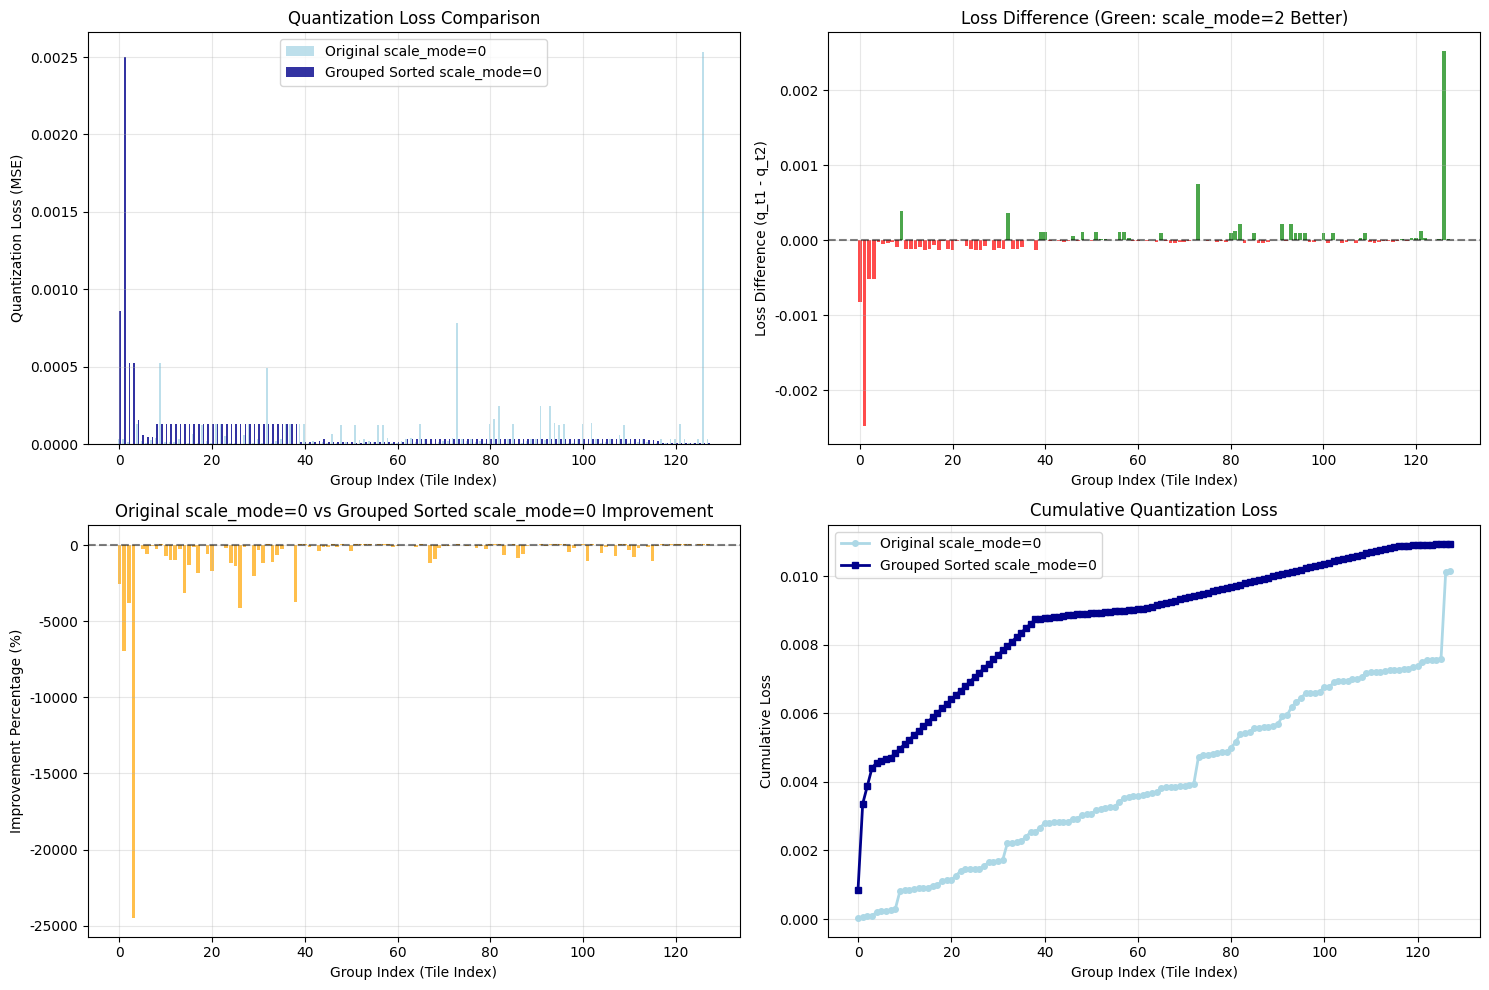

Quantization Loss Statistical Analysis
Metric               Original scale_mode=0 Grouped Sorted scale_mode=0 Improvement%
------------------------------------------------------------
Average Loss         0.000079        0.000086        -595.17   
Total Loss           0.010161        0.010949        -7.75     
Max Loss             0.002533        0.002503        99.68     
Min Loss             0.000002        0.000005        -24495.48 
Std Dev              0.000240        0.000238       


In [ ]:
def scatter_largest_to_groups(sorted_idx, block_size):
    N = sorted_idx.shape[-1]
    num_groups = N // block_size
    grouped_idx = torch.empty_like(sorted_idx)
    for i in range(N):
        group = i % num_groups
        pos_in_group = i // num_groups
        grouped_idx[group * block_size + pos_in_group] = sorted_idx[i]
    return grouped_idx

grouped_sorted_idx = scatter_largest_to_groups(index, block_size=32)
# 使用分组后的索引对原始token进行分组
grouped_sorted_token = token[grouped_sorted_idx]
grouped_sorted_q_t1 = quantize_mx_op(grouped_sorted_token,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)    
# 计算分组后的量化损失
grouped_sorted_q_t1_loss = compute_tile_quantization_loss(grouped_sorted_token, grouped_sorted_q_t1,
                                                          block_size=32, loss_type='mse')
# 绘制详细分析图
plot_detailed_quantization_analysis(q_t1_loss, grouped_sorted_q_t1_loss, 'Original scale_mode=0',
                                    'Grouped Sorted scale_mode=0')

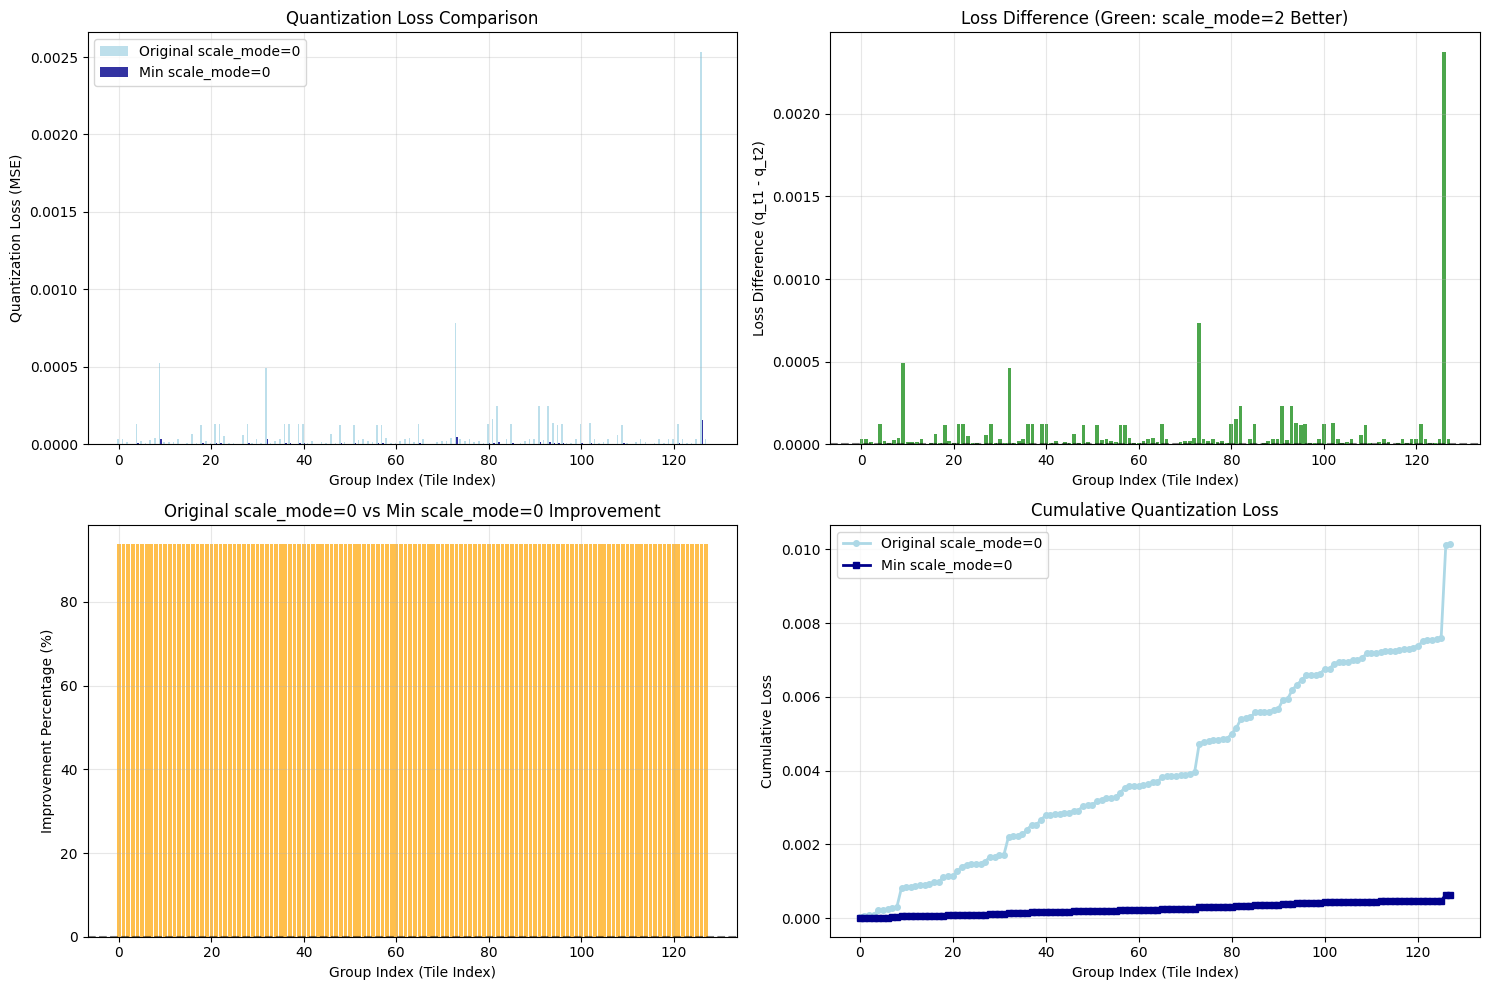

Quantization Loss Statistical Analysis
Metric               Original scale_mode=0 Min scale_mode=0 Improvement%
------------------------------------------------------------
Average Loss         0.000079        0.000005        93.75     
Total Loss           0.010161        0.000635        93.75     
Max Loss             0.002533        0.000158        93.75     
Min Loss             0.000002        0.000000        93.75     
Std Dev              0.000240        0.000015       


: 

In [ ]:
token_min = token / 4
q_t1_min = quantize_mx_op(token_min,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                        axes=-1,
                        scale_mode=0,)
q_t1_min_loss = compute_tile_quantization_loss(token_min, q_t1_min, block_size=32, loss_type='mse')

# 绘制详细分析图
plot_detailed_quantization_analysis(q_t1_loss, q_t1_min_loss, 'Original scale_mode=0',
                                    'Min scale_mode=0')

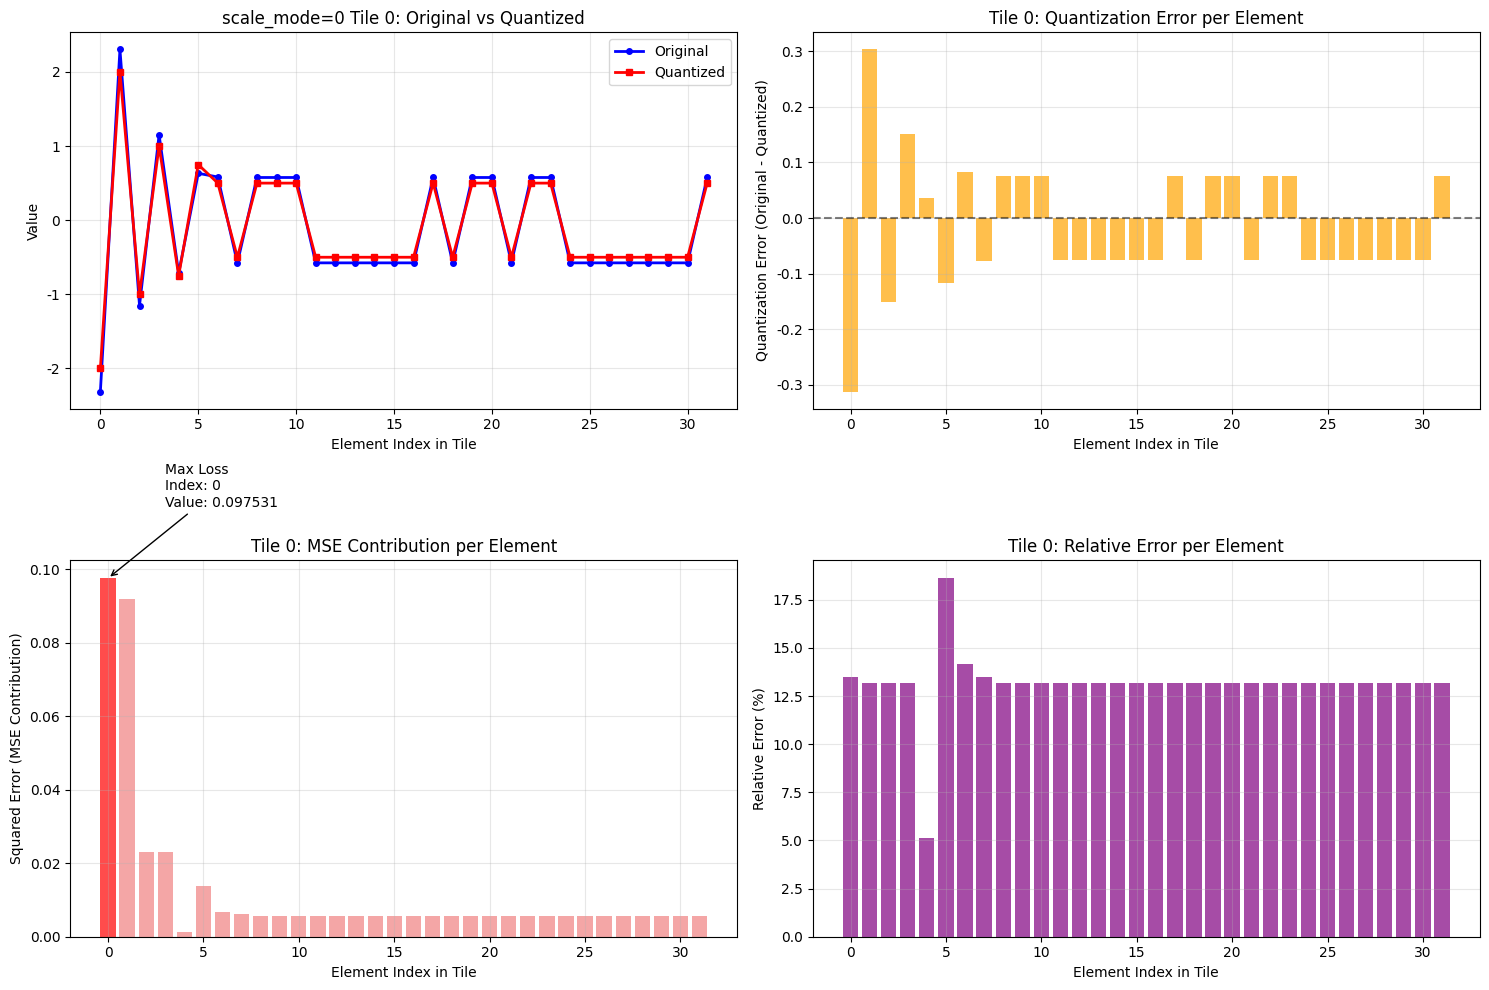

Detailed Analysis for scale_mode=0 Tile 0
Tile MSE: 0.01254844
Tile Max Squared Error: 0.09753127 (at index 0)
Tile Min Squared Error: 0.00132778
Tile Mean Absolute Error: 0.09541485

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
0        -2.312300    -2.000000    -0.312300    0.09753127      13.51       
1        2.303267     2.000000     0.303267     0.09197117      13.17       
3        1.151634     1.000000     0.151634     0.02299279      13.17       
2        -1.151634    -1.000000    -0.151634    0.02299279      13.17       
5        0.632270     0.750000     -0.117730    0.01386047      18.62       


In [ ]:
# 分析第0组的详细情况
analyze_tile_details(sorted_token, sorted_q_t1, tile_index=0, title_prefix="scale_mode=0 ")

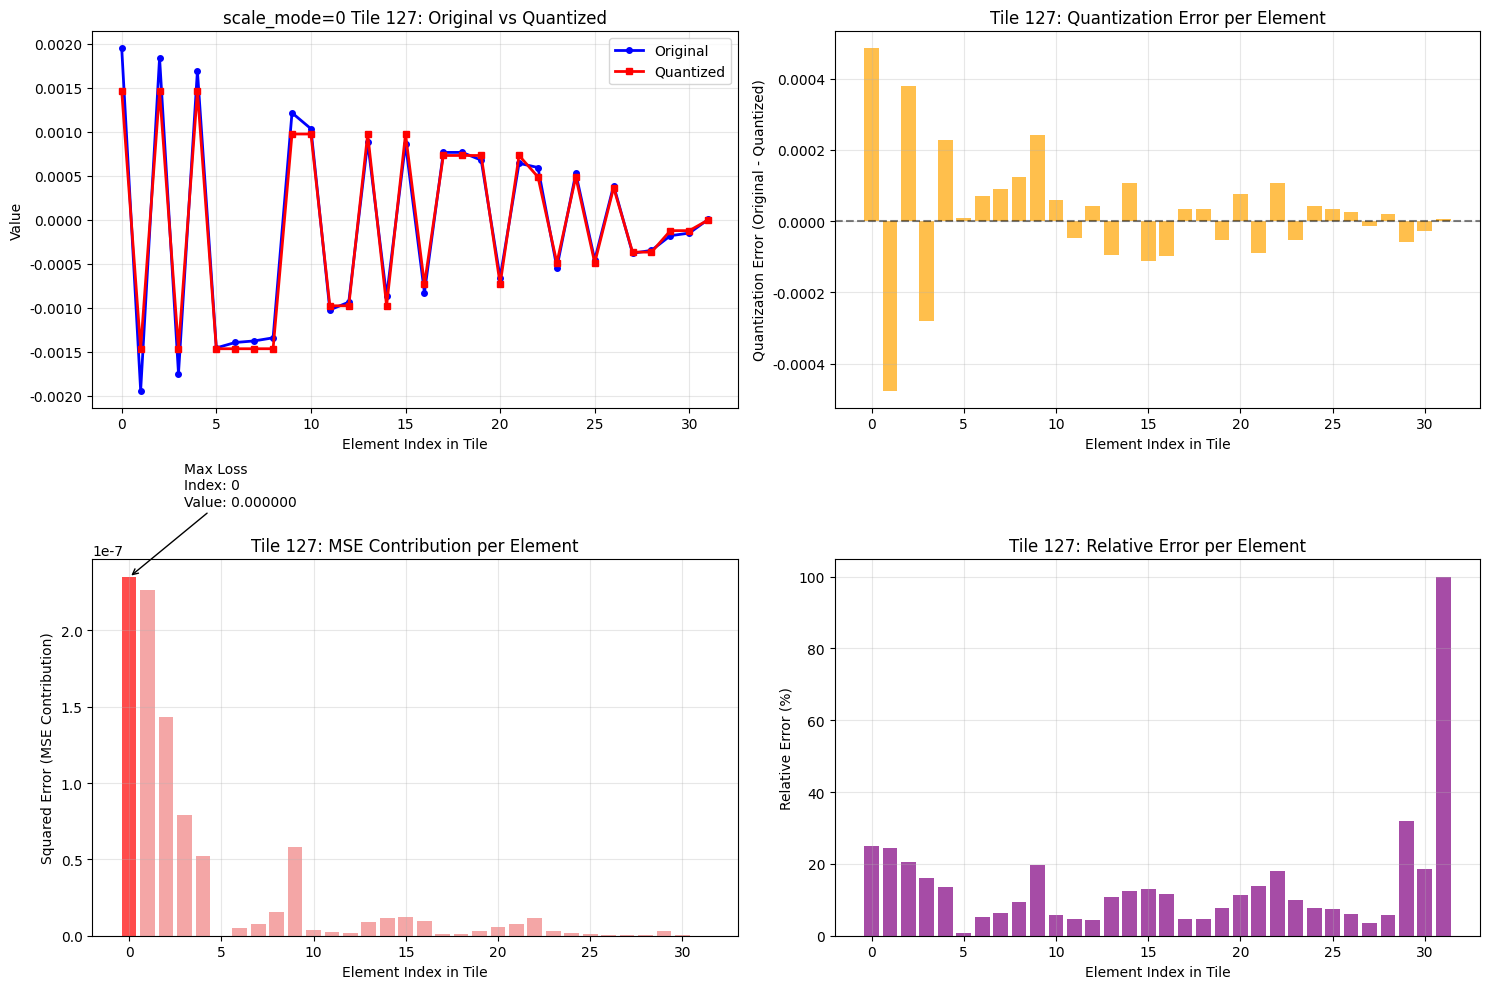

Detailed Analysis for scale_mode=0 Tile 127
Tile MSE: 0.00000003
Tile Max Squared Error: 0.00000023 (at index 0)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.00011294

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
0        0.001949     0.001465     0.000485     0.00000023      24.86       
1        -0.001941    -0.001465    -0.000476    0.00000023      24.51       
2        0.001844     0.001465     0.000379     0.00000014      20.54       
3        -0.001747    -0.001465    -0.000282    0.00000008      16.13       
9        0.001217     0.000977     0.000241     0.00000006      19.77       


In [ ]:
# 分析第127组的详细情况
analyze_tile_details(sorted_token, sorted_q_t1, tile_index=127, title_prefix="scale_mode=0 ")

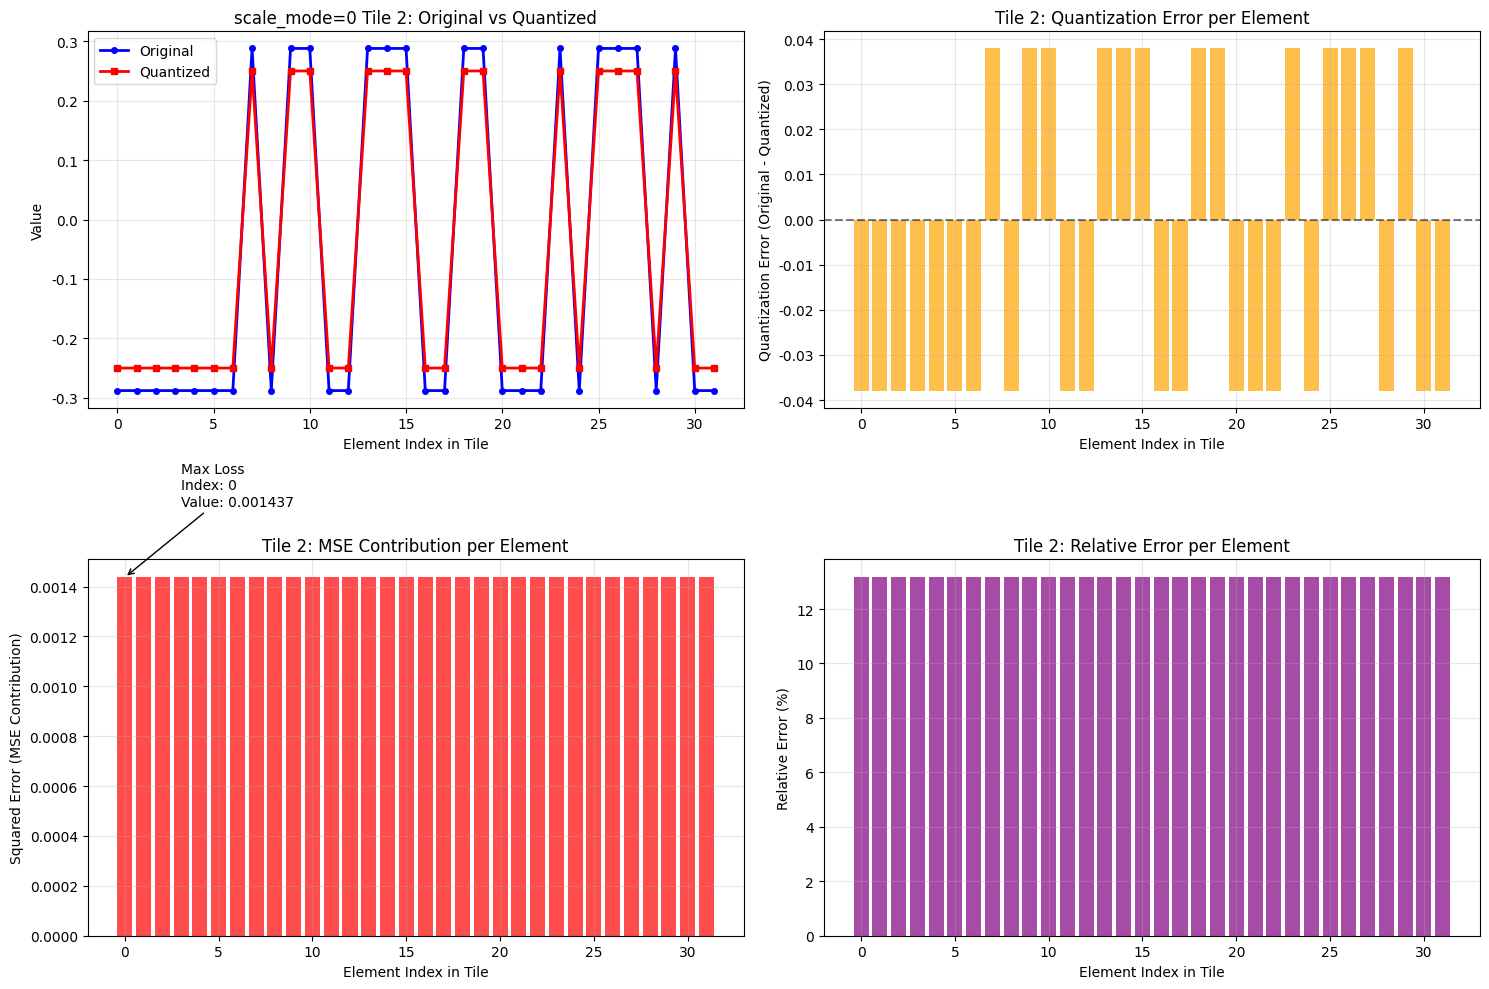

Detailed Analysis for scale_mode=0 Tile 2
Tile MSE: 0.00143705
Tile Max Squared Error: 0.00143705 (at index 0)
Tile Min Squared Error: 0.00143705
Tile Mean Absolute Error: 0.03790843

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
31       -0.287908    -0.250000    -0.037908    0.00143705      13.17       
30       -0.287908    -0.250000    -0.037908    0.00143705      13.17       
29       0.287908     0.250000     0.037908     0.00143705      13.17       
28       -0.287908    -0.250000    -0.037908    0.00143705      13.17       
27       0.287908     0.250000     0.037908     0.00143705      13.17       


In [ ]:
# 分析第2组的详细情况
analyze_tile_details(sorted_token, sorted_q_t1, tile_index=2, title_prefix="scale_mode=0 ")

In [ ]:
sorted_roted_t =  hadamard_transform(sorted_token.reshape(-1, sorted_token.shape[0] // 32,
                                                      32), scale=1 / math.sqrt(32)).reshape(-1)
sorted_p_rt1 = quantize_mx_op(sorted_roted_t,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)

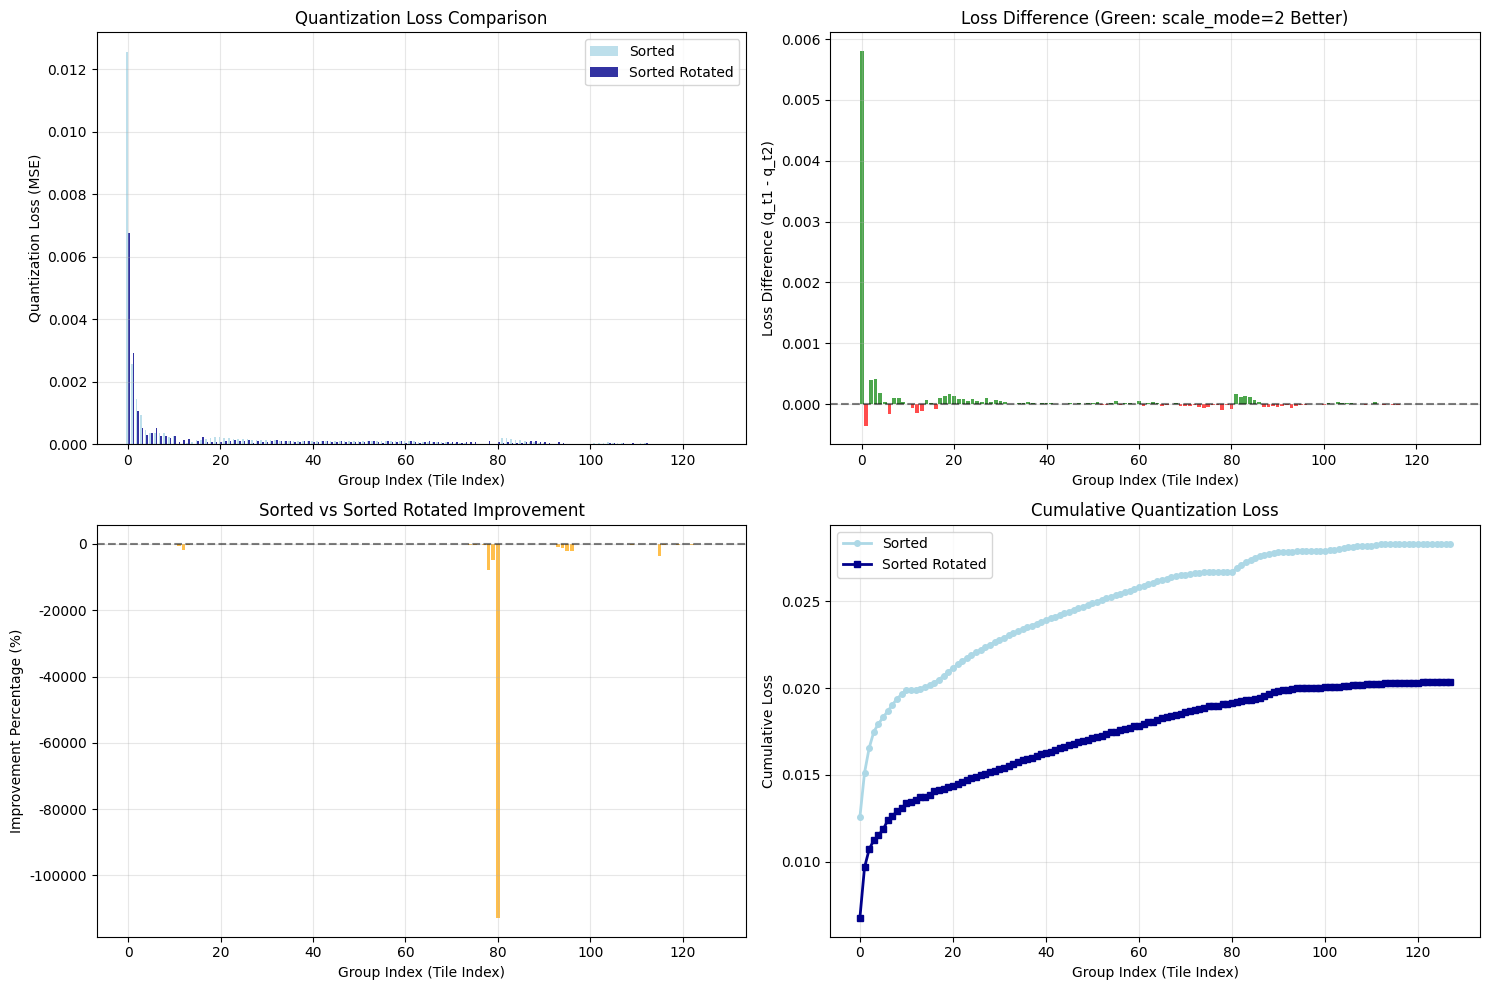

Quantization Loss Statistical Analysis
Metric               Sorted          Sorted Rotated  Improvement%
------------------------------------------------------------
Average Loss         0.000221        0.000159        -1085.96  
Total Loss           0.028328        0.020326        28.25     
Max Loss             0.012548        0.006746        97.38     
Min Loss             0.000000        0.000000        -112824.66
Std Dev              0.001127        0.000646       


In [ ]:
sorted_p_rt1_loss = compute_tile_quantization_loss(sorted_roted_t, sorted_p_rt1,
                                                  block_size=32, loss_type='mse')
# 绘制详细分析图
plot_detailed_quantization_analysis(sorted_q_t1_loss, sorted_p_rt1_loss, 'Sorted',
                                    'Sorted Rotated')

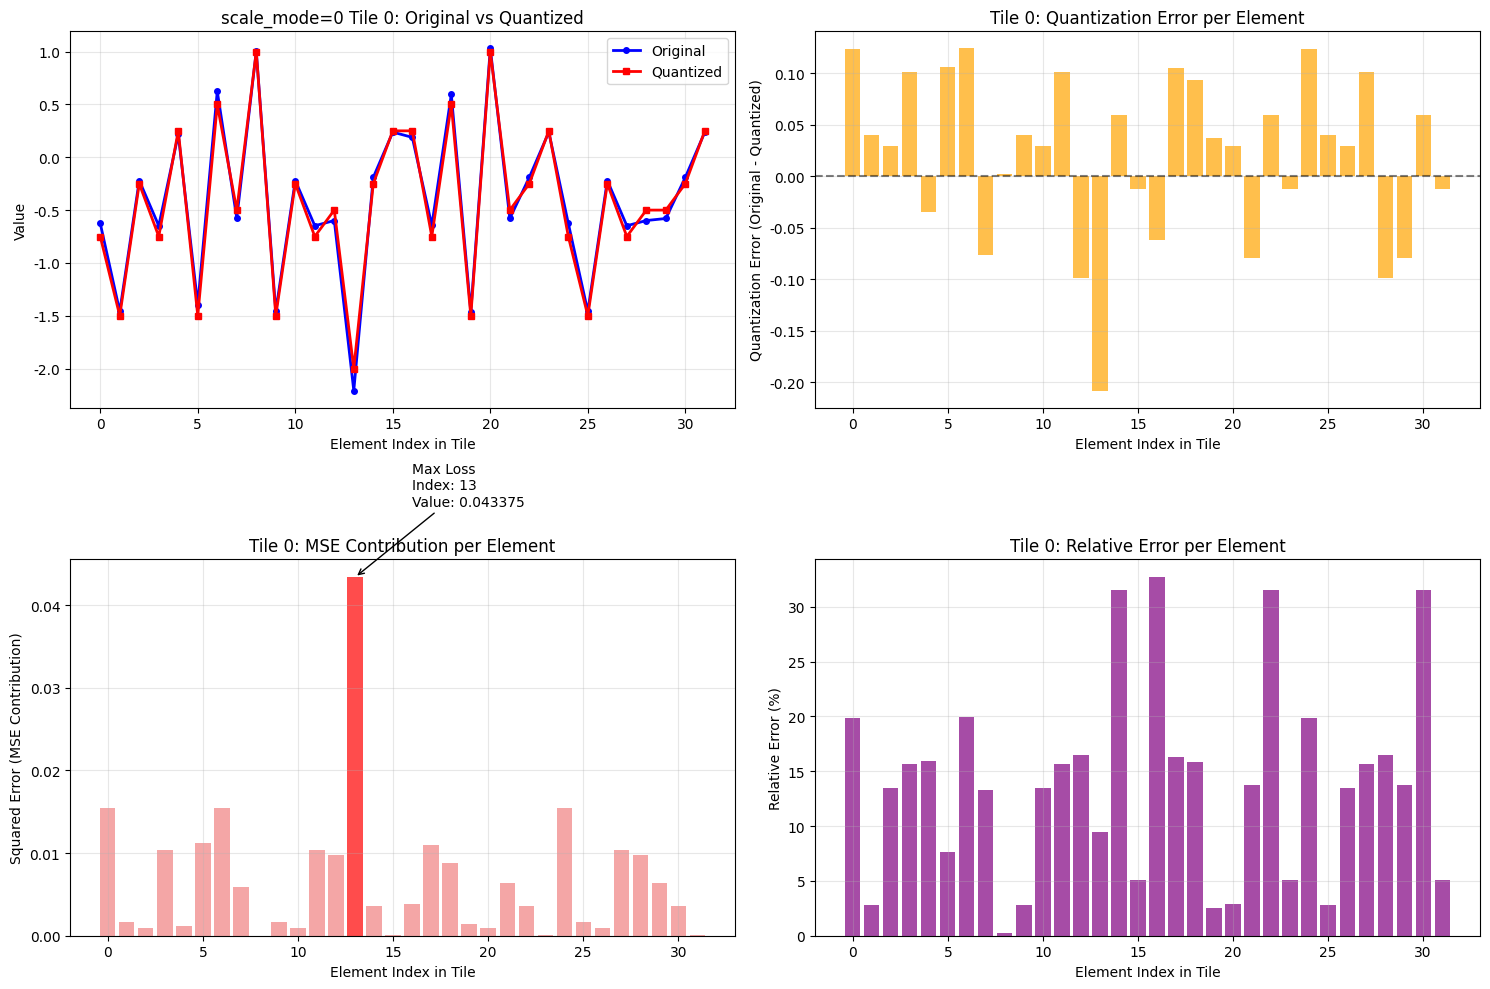

Detailed Analysis for scale_mode=0 Tile 0
Tile MSE: 0.00674638
Tile Max Squared Error: 0.04337464 (at index 13)
Tile Min Squared Error: 0.00000751
Tile Mean Absolute Error: 0.06928544

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
13       -2.208266    -2.000000    -0.208266    0.04337464      9.43        
6        0.624318     0.500000     0.124318     0.01545500      19.91       
24       -0.625915    -0.750000    0.124085     0.01539712      19.82       
0        -0.625915    -0.750000    0.124085     0.01539712      19.82       
5        -1.393938    -1.500000    0.106062     0.01124916      7.61        


In [ ]:
# 绘制第0组的详细情况
analyze_tile_details(sorted_roted_t, sorted_p_rt1, tile_index=0, title_prefix="scale_mode=0 ")

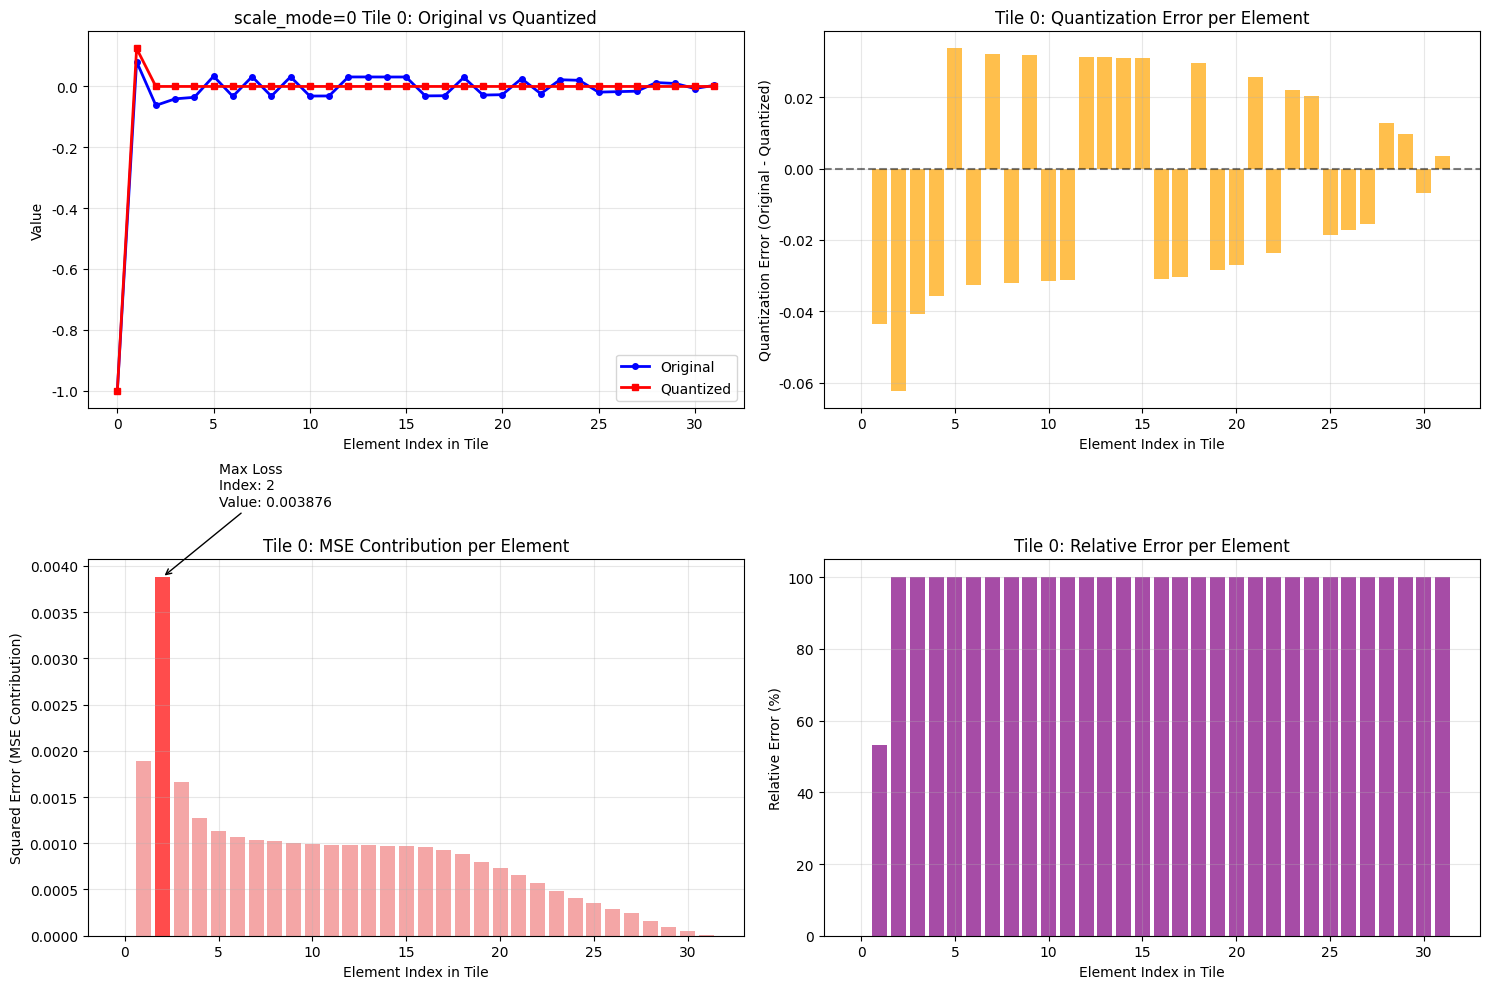

Detailed Analysis for scale_mode=0 Tile 0
Tile MSE: 0.00085822
Tile Max Squared Error: 0.00387579 (at index 2)
Tile Min Squared Error: 0.00000000
Tile Mean Absolute Error: 0.02670765

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
2        -0.062256    0.000000     -0.062256    0.00387579      100.00      
1        0.081543     0.125000     -0.043457    0.00188851      53.29       
3        -0.040771    0.000000     -0.040771    0.00166231      100.00      
4        -0.035645    0.000000     -0.035645    0.00127053      100.00      
5        0.033691     0.000000     0.033691     0.00113511      100.00      


In [ ]:
analyze_tile_details(grouped_sorted_token, grouped_sorted_q_t1, tile_index=0, title_prefix="scale_mode=0 ")

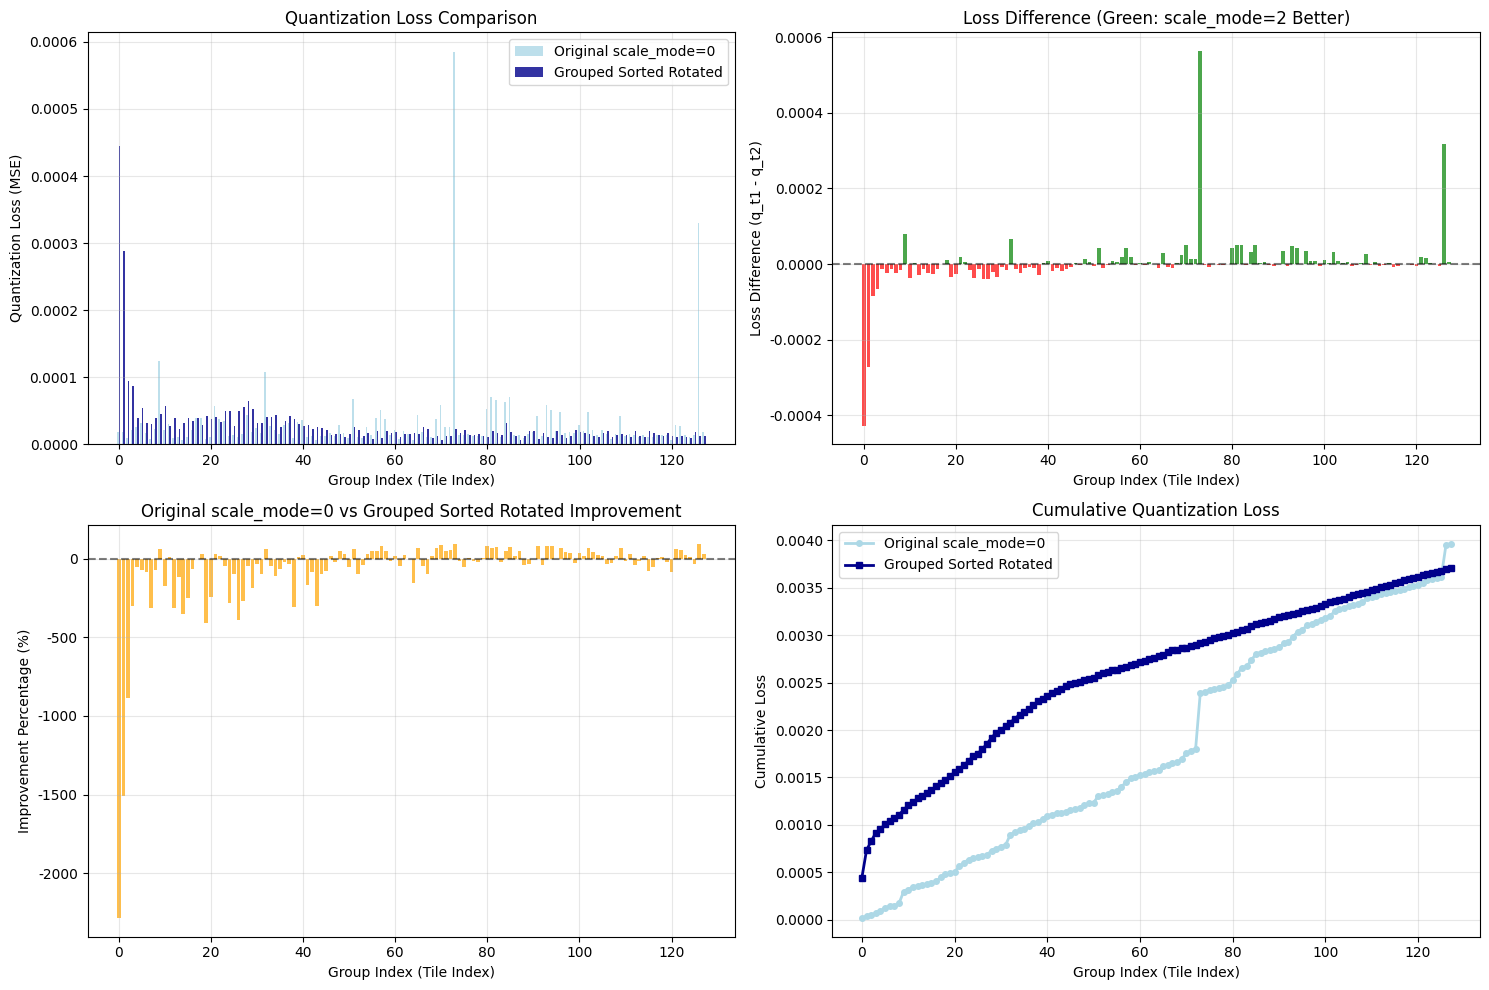

Quantization Loss Statistical Analysis
Metric               Original scale_mode=0 Grouped Sorted Rotated Improvement%
------------------------------------------------------------
Average Loss         0.000031        0.000029        -69.66    
Total Loss           0.003966        0.003706        6.57      
Max Loss             0.000585        0.000445        96.20     
Min Loss             0.000006        0.000007        -2284.81  
Std Dev              0.000059        0.000046       


In [ ]:
grouped_sorted_roted_t =  hadamard_transform(grouped_sorted_token.reshape(-1, grouped_sorted_token.shape[0] // 32,
                                                      32), scale=1 / math.sqrt(32)).reshape(-1)
grouped_sorted_p_rt1 = quantize_mx_op(grouped_sorted_roted_t,
                      mx_specs,
                      elem_format="fp4_e2m1",
                      block_size=32,
                      axes=-1,
                      scale_mode=0,)
grouped_sorted_p_rt1_loss = compute_tile_quantization_loss(grouped_sorted_roted_t, grouped_sorted_p_rt1,
                                                          block_size=32, loss_type='mse')
# 绘制详细分析图
plot_detailed_quantization_analysis(p_rt1_loss, grouped_sorted_p_rt1_loss, 'Original scale_mode=0',
                                    'Grouped Sorted Rotated')

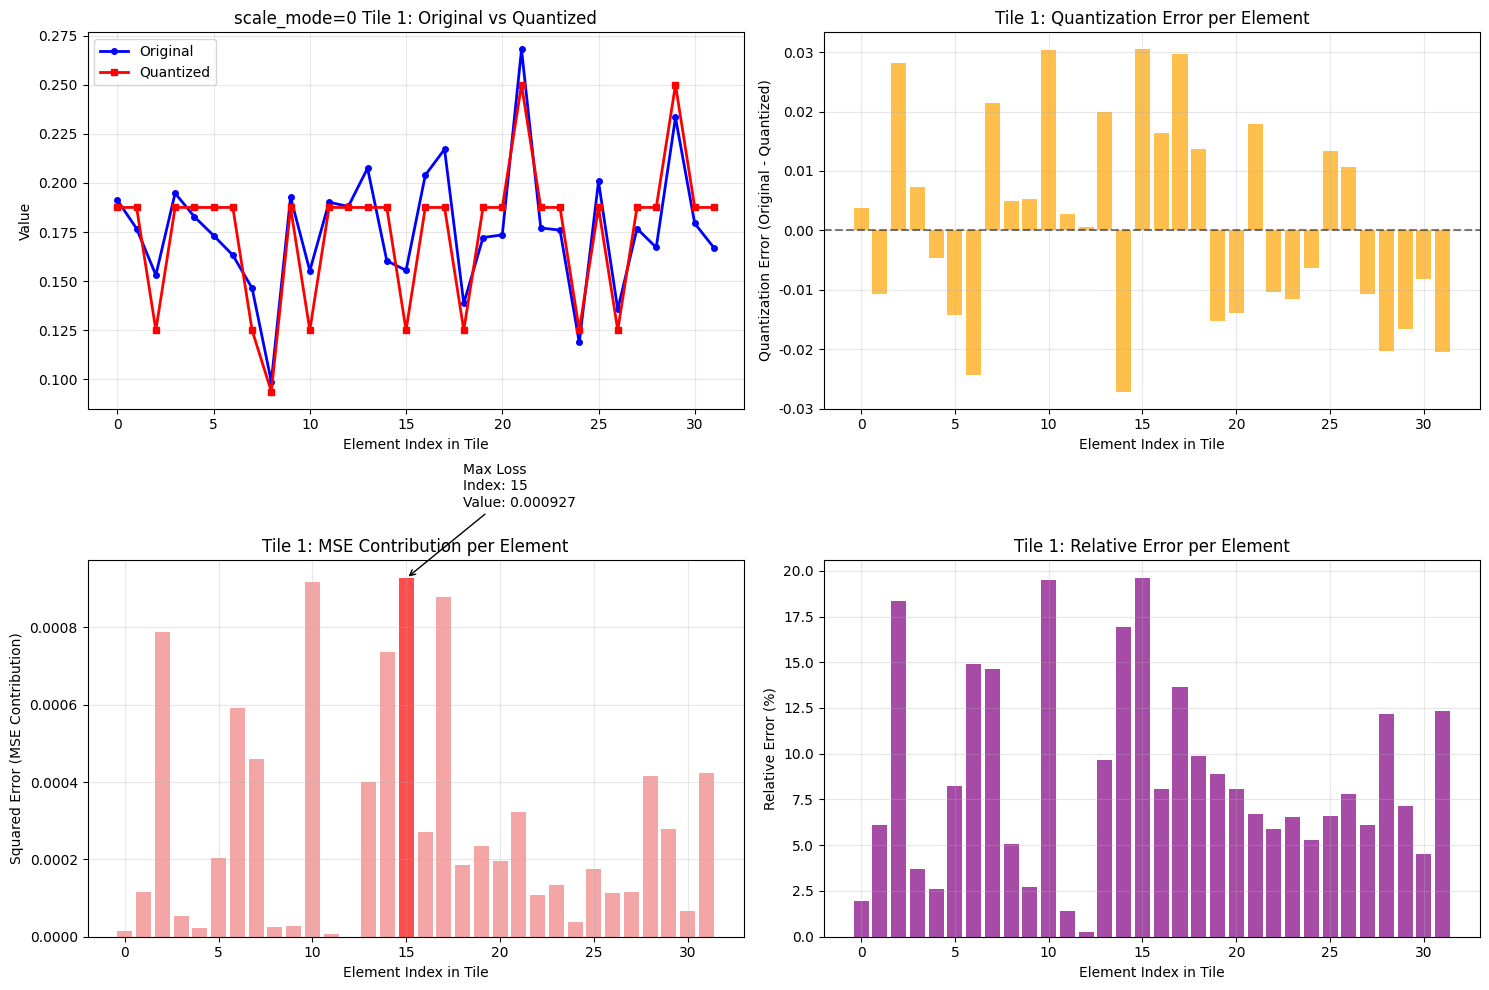

Detailed Analysis for scale_mode=0 Tile 1
Tile MSE: 0.00028884
Tile Max Squared Error: 0.00092727 (at index 15)
Tile Min Squared Error: 0.00000024
Tile Mean Absolute Error: 0.01473228

Top 5 elements with highest squared error:
Index    Original     Quantized    Error        Squared Error   Rel Error % 
--------------------------------------------------------------------------------
15       0.155451     0.125000     0.030451     0.00092727      19.59       
10       0.155278     0.125000     0.030278     0.00091678      19.50       
17       0.217124     0.187500     0.029624     0.00087760      13.64       
2        0.153088     0.125000     0.028088     0.00078894      18.35       
14       0.160360     0.187500     -0.027140    0.00073656      16.92       


In [ ]:
analyze_tile_details(grouped_sorted_roted_t, grouped_sorted_p_rt1, tile_index=1, title_prefix="scale_mode=0 ")